# Libs

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [ ]:
dat = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/agg_data (1).pkll')
print(dat.shape)
dat.head()

(307505, 363)


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_SIZE_SUM,CLOSED_NEW_DEPT_RATIO_MIN,CLOSED_NEW_DEPT_RATIO_MAX,CLOSED_NEW_DEPT_RATIO_MEAN,TARGET
0,0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,...,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,1
1,1,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
temp, test = train_test_split(dat, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209103, 363), (52276, 363), (46126, 363))

# LGBM

In [ ]:
train_lgb = copy.deepcopy(train)
valid_lgb = copy.deepcopy(valid)
test_lgb = copy.deepcopy(test)

In [ ]:
for col in train_lgb.columns:
    if '-' in col or ':' in col:
        print(col)

PREV_NAME_PRODUCT_TYPE_walk-in_MEAN
PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN


In [ ]:
train_lgb = train_lgb.rename(columns = {'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN': 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
                                       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN': 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN'})

valid_lgb = valid_lgb.rename(columns = {'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN': 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
                                       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN': 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN'})

test_lgb = test_lgb.rename(columns = {'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN': 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
                                       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN': 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN'})

## LGBM + fullvars

In [ ]:
lgb_train = lgb.Dataset(data=train_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                        label=train_lgb.TARGET)
lgb_valid = lgb.Dataset(data=valid_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                       label=valid_lgb.TARGET)
lgb_test = lgb.Dataset(data=test_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                      label= test_lgb.TARGET)

In [ ]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 20,
          'max_bin': 20,
          'num_iteration': 1000,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1}
model_lgb_base = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=200,
                      valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=50)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16988, number of negative: 192115
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.332327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6787
[LightGBM] [Info] Number of data points in the train set: 209103, number of used features: 361
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081242 -> initscore=-2.425587
[LightGBM] [Info] Start training from score -2.425587
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.744153	valid_1's auc: 0.742292
[100]	training's auc: 0.752118	valid_1's auc: 0.748799
[150]	training's auc: 0.759666	valid_1's auc: 0.75432
[200]	training's auc: 0.766537	valid_1's auc: 0.7596

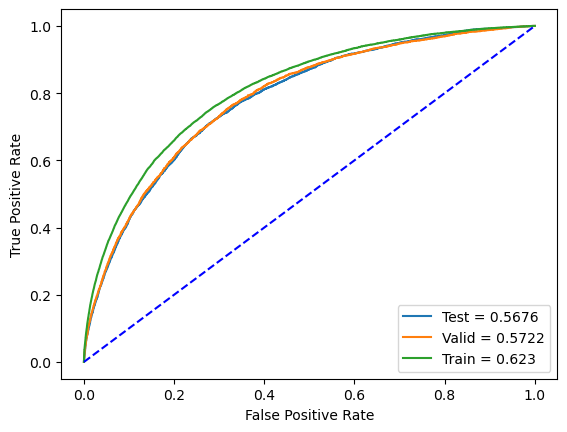

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = model_lgb_base.predict(test_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_valid = model_lgb_base.predict(valid_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_train = model_lgb_base.predict(train_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))

plot_roc_curve(true_y = (test_lgb['TARGET'], valid_lgb['TARGET'], train_lgb['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model_lgb_base.feature_importance(),test_lgb.columns)),
                           columns=['Value','Feature'])
feature_imp

,Value,Feature
0,0,APPROVED_DAYS_FIRST_DUE_MEDIAN
1,0,APPROVED_DAYS_FIRST_DUE_MIN
2,0,APPROVED_NEW_AMT_CREDIT_RATIO_MEDIAN
3,0,CC_AMT_DRAWINGS_CURRENT_MEAN
4,0,CC_AMT_RECIVABLE_SUM
...,...,...
356,378,EXT_SOURCE_1
357,400,AMT_ANNUITY
358,424,NEW_PAYMENT_RATIO
359,434,INSTAL_DPD_MAX


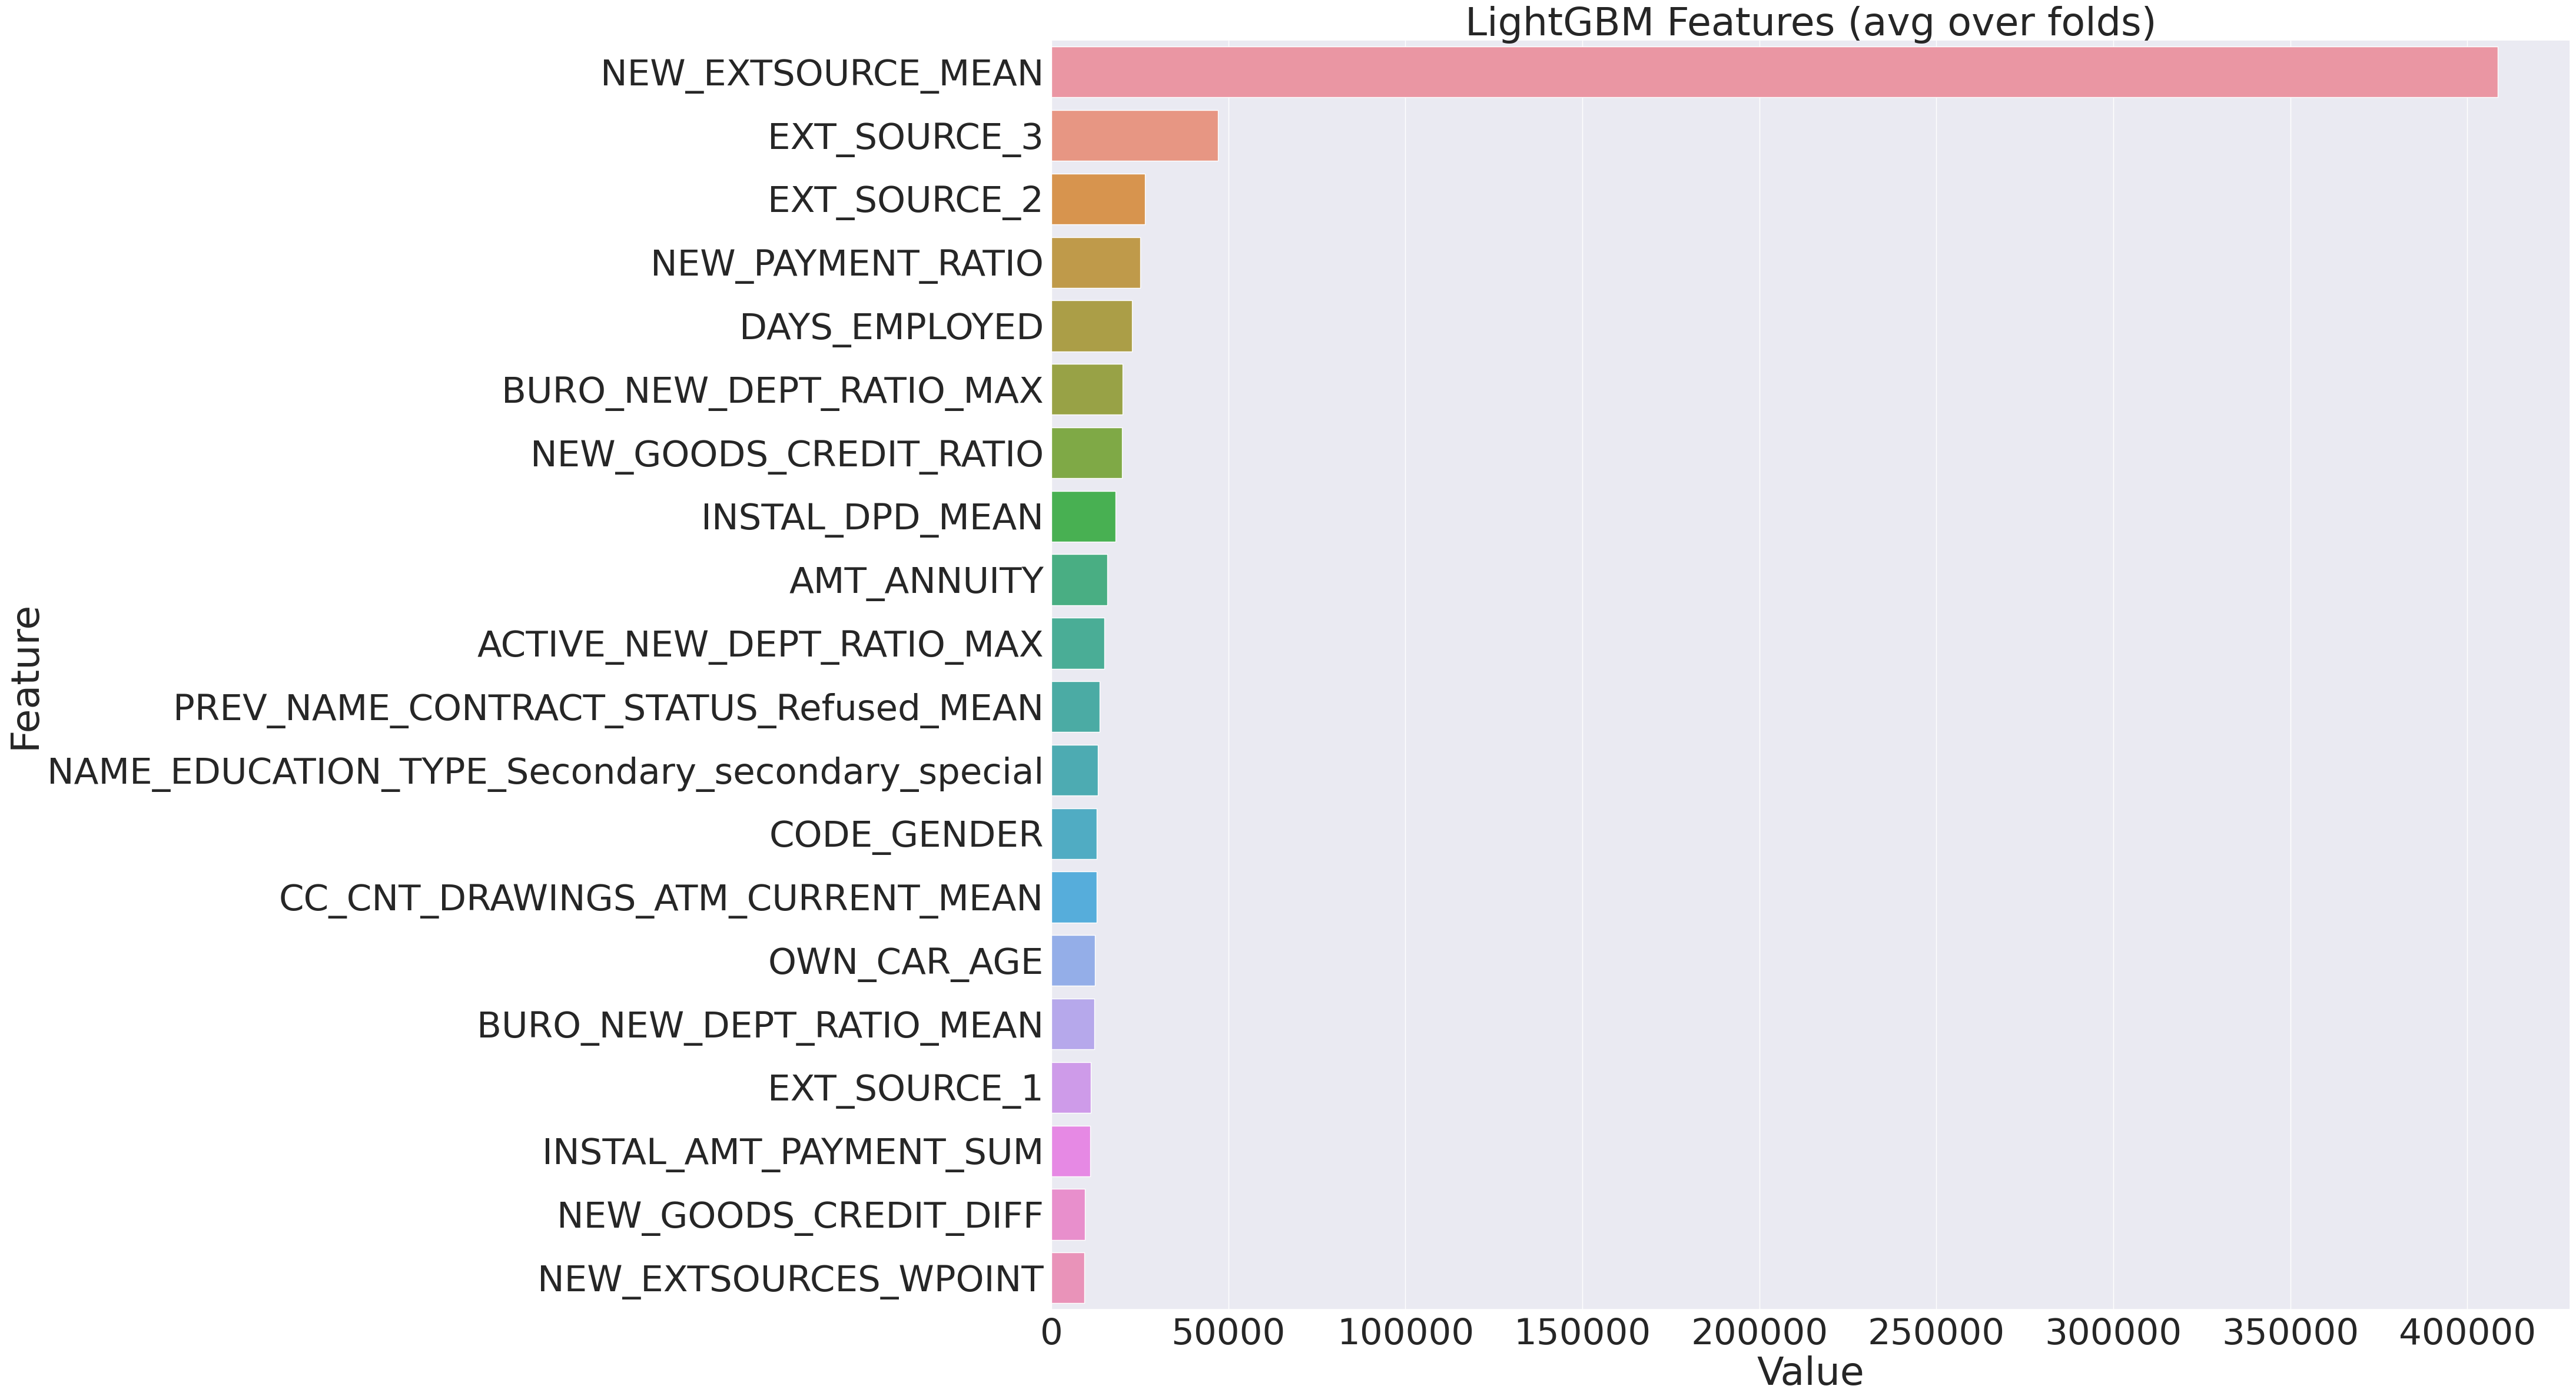

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def plotImp(model , num = 20, fig_size = (45, 25)):
#     print(len(model.feature_importance()))
#     print(len(X.columns))
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type = 'gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 4)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

plotImp(model = model_lgb_base)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

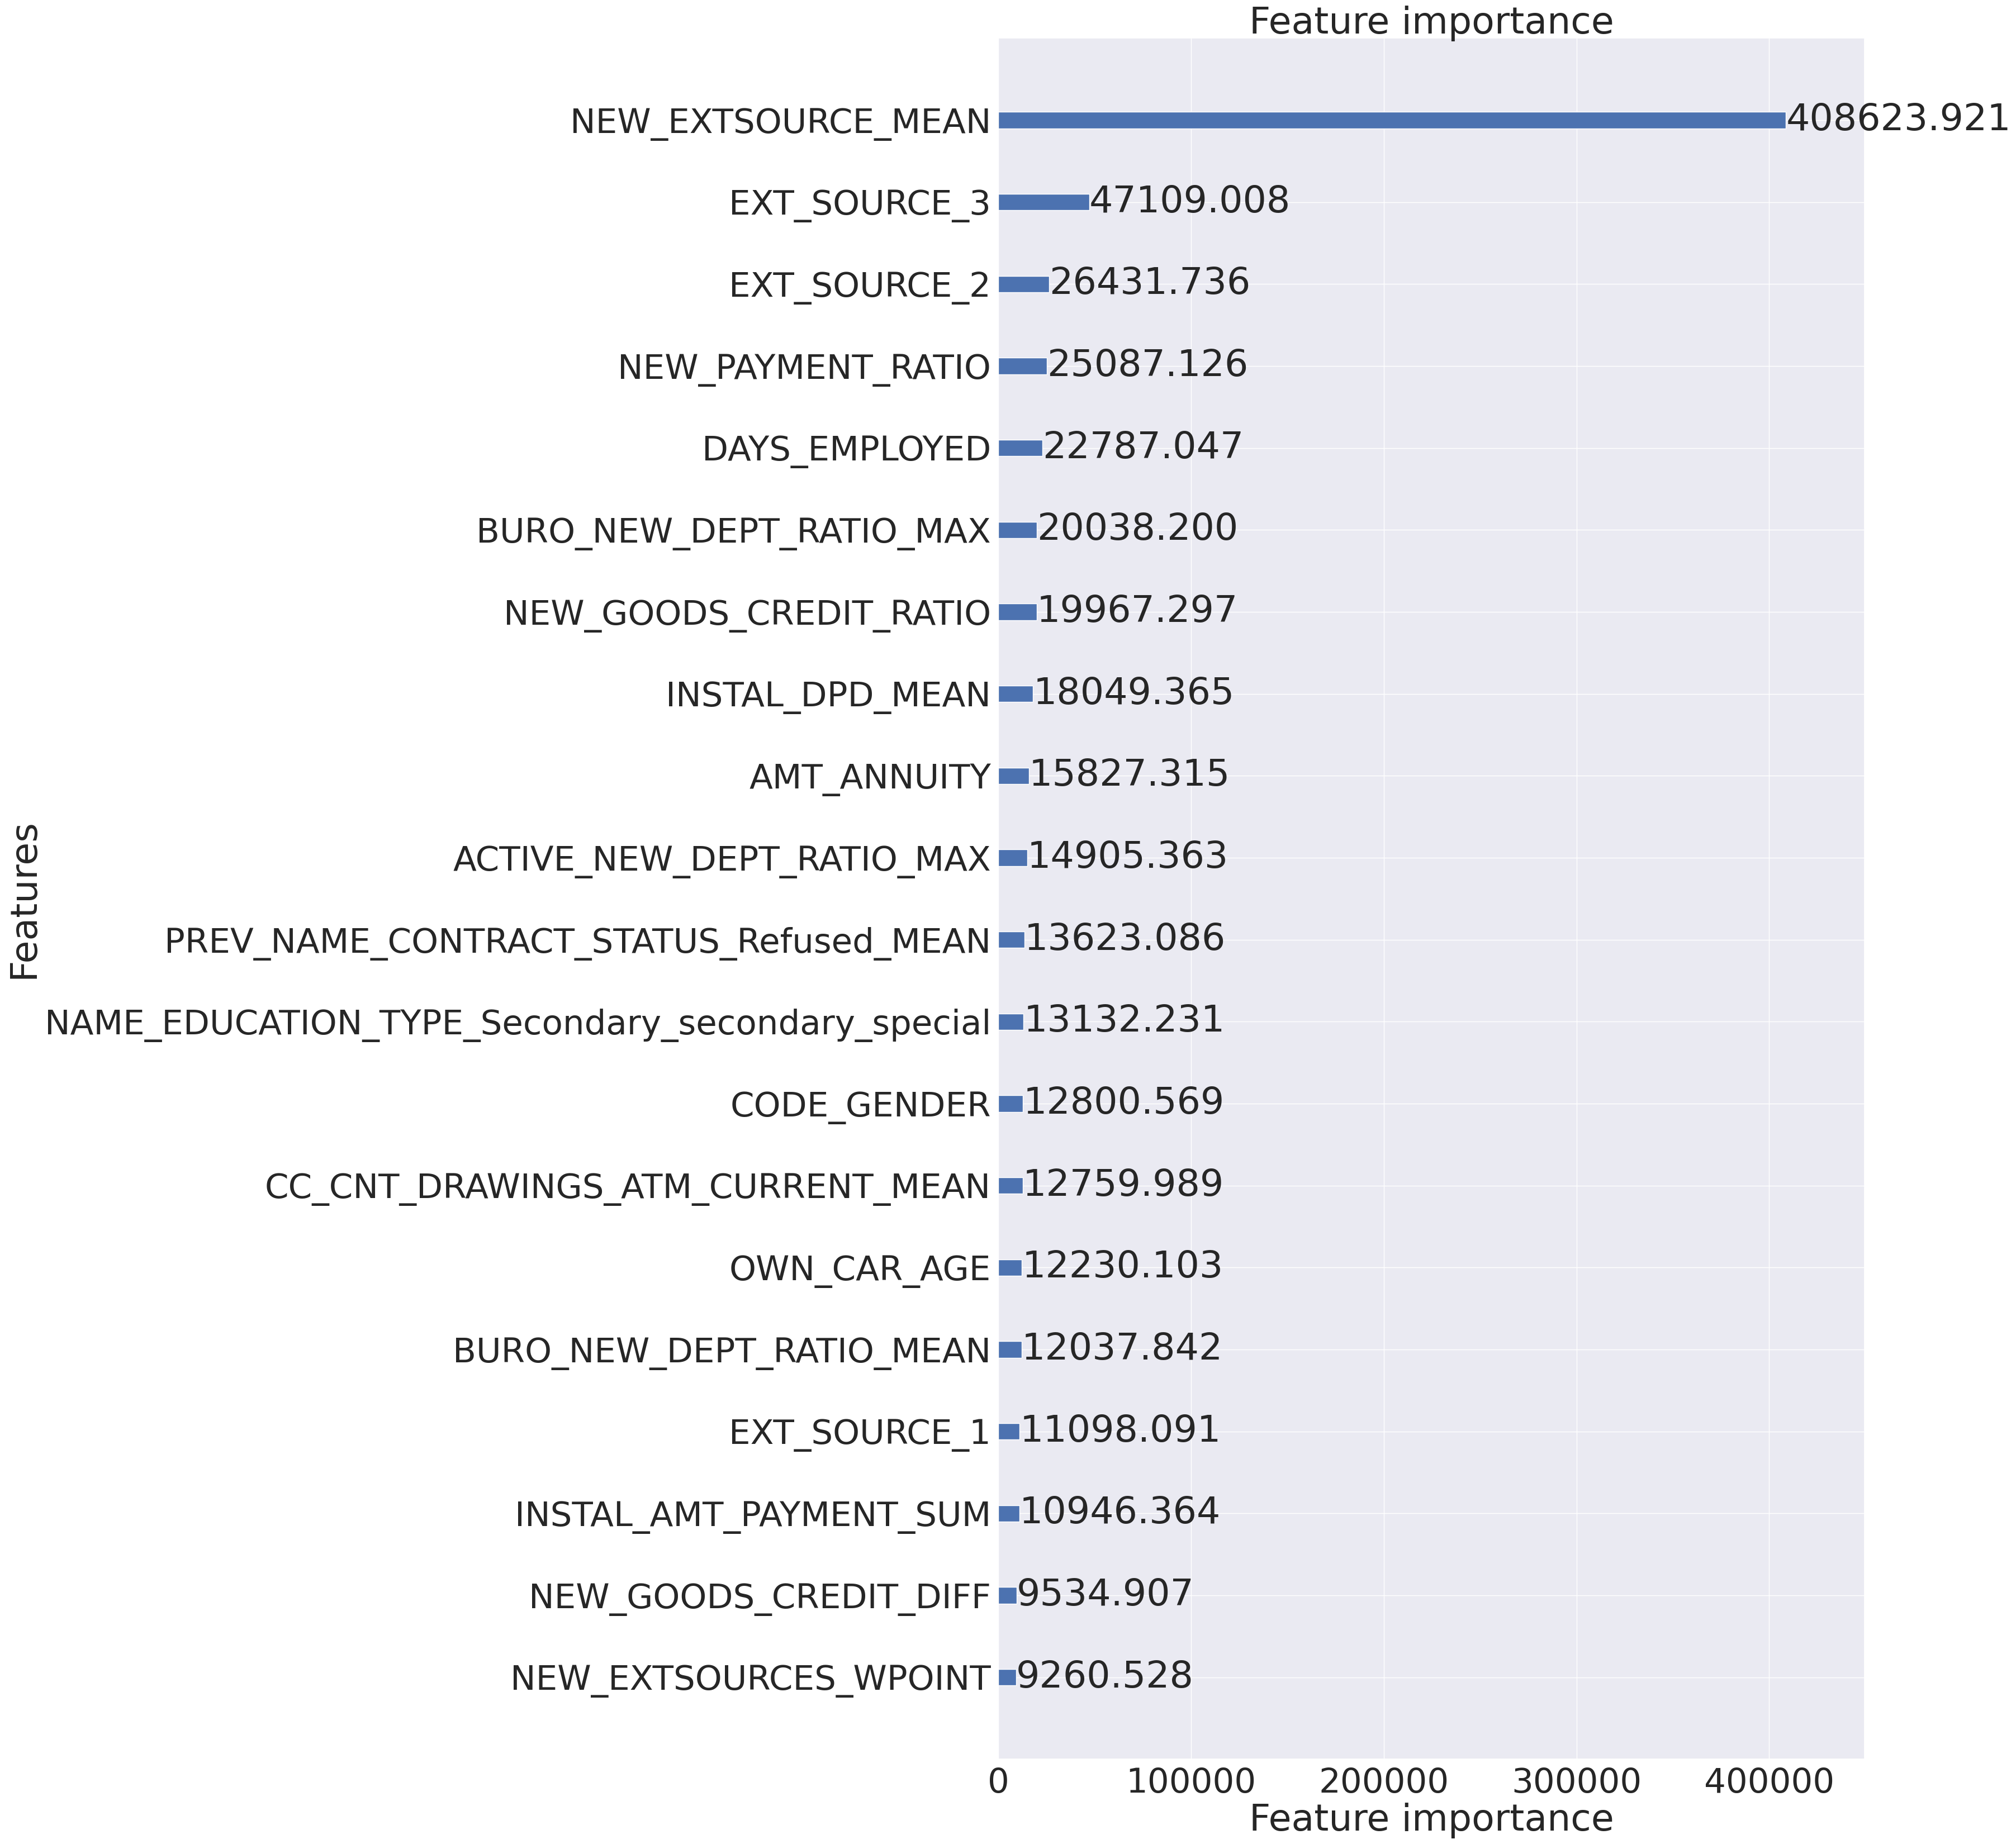

In [ ]:
lgb.plot_importance(model_lgb_base, importance_type = 'gain', max_num_features = 20,
                   figsize = (20, 40))

## LGBM + stepwise(p-value) selection

In [ ]:
included = ['CODE_GENDER',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'DAYS_REGISTRATION',
  'DAYS_ID_PUBLISH',
  'OWN_CAR_AGE',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'YEARS_BEGINEXPLUATATION_AVG',
  'APARTMENTS_MODE',
  'YEARS_BEGINEXPLUATATION_MEDI',
  'ELEVATORS_MEDI',
  'DAYS_LAST_PHONE_CHANGE',
  'NEW_DOCUMENT',
  'NEW_DAYS_EMPLOYED_RATIO',
  'NEW_PAYMENT_RATIO',
  'NEW_EXTSOURCE_MEAN',
  'NEW_EXTSOURCES_WPOINT',
  'NEW_GOODS_CREDIT_DIFF_RATIO',
  'NAME_INCOME_TYPE_Working',
  'NAME_EDUCATION_TYPE_Secondary_secondary_special',
  'OCCUPATION_TYPE_Laborers',
  'ORGANIZATION_TYPE_XNA',
  'NEW_SEGMENT_AGE_Old',
  'NEW_SEGMENT_AGE_Young',
  'POS_MONTHS_BALANCE_SIZE_Cfull',
  'POS_COUNT',
  'INSTAL_DPD_MEAN',
  'INSTAL_PAYMENT_DIFF_MAX',
  'INSTAL_PAYMENT_DIFF_MEAN',
  'INSTAL_AMT_INSTALMENT_MAX',
  'INSTAL_AMT_INSTALMENT_MEAN',
  'INSTAL_AMT_INSTALMENT_SUM',
  'INSTAL_AMT_PAYMENT_MEAN',
  'INSTAL_AMT_PAYMENT_SUM',
  'PREV_AMT_ANNUITY_MIN',
  'PREV_AMT_ANNUITY_MEAN',
  'PREV_AMT_DOWN_PAYMENT_MEDIAN',
  'PREV_HOUR_APPR_PROCESS_START_MEAN',
  'PREV_CNT_PAYMENT_MAX',
  'PREV_DAYS_FIRST_DUE_MEAN',
  'PREV_DAYS_FIRST_DUE_MEDIAN',
  'PREV_DAYS_LAST_DUE_1ST_VERSION_MIN',
  'PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN',
  'PREV_DAYS_LAST_DUE_MIN',
  'PREV_NEW_AMT_CREDIT_RATIO_MAX',
  'PREV_NEW_AMT_CREDIT_RATIO_MEAN',
  'PREV_NEW_AMT_CREDIT_RATIO_MEDIAN',
  'PREV_NEW_INSURED_ON_APPROVAL_MEAN',
  'PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN',
  'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
  'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
  'PREV_NAME_YIELD_GROUP_high_MEAN',
  'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN',
  'PREV_NEW_FLAG_LATE_DAYS_NaN_MEAN',
  'APPROVED_AMT_ANNUITY_MEDIAN',
  'APPROVED_AMT_APPLICATION_MEDIAN',
  'APPROVED_AMT_CREDIT_MEAN',
  'APPROVED_AMT_GOODS_PRICE_MAX',
  'APPROVED_AMT_GOODS_PRICE_MEDIAN',
  'APPROVED_HOUR_APPR_PROCESS_START_MAX',
  'APPROVED_RATE_DOWN_PAYMENT_MAX',
  'APPROVED_DAYS_DECISION_MEDIAN',
  'APPROVED_DAYS_FIRST_DUE_MEAN',
  'APPROVED_DAYS_FIRST_DUE_MEDIAN',
  'APPROVED_DAYS_LAST_DUE_1ST_VERSION_MIN',
  'APPROVED_DAYS_LAST_DUE_1ST_VERSION_MEAN',
  'APPROVED_DAYS_LAST_DUE_MIN',
  'APPROVED_NEWX2_FLAG_AMT_CREDIT_RATIO_MIN',
  'APPROVED_NEWX2_FLAG_AMT_CREDIT_RATIO_MEAN',
  'REFUSED_AMT_ANNUITY_MAX',
  'REFUSED_AMT_CREDIT_MIN',
  'REFUSED_AMT_CREDIT_MEAN',
  'REFUSED_AMT_GOODS_PRICE_MEAN',
  'REFUSED_HOUR_APPR_PROCESS_START_MIN',
  'REFUSED_DAYS_DECISION_MEAN',
  'REFUSED_CNT_PAYMENT_MAX',
  'REFUSED_CNT_PAYMENT_MEAN',
  'REFUSED_CNT_PAYMENT_MEDIAN',
  'REFUSED_NEW_AMT_CREDIT_RATIO_MEAN',
  'REFUSED_NEWX2_FLAG_AMT_CREDIT_RATIO_MIN',
  'REFUSED_NEWX2_FLAG_AMT_CREDIT_RATIO_MAX',
  'REFUSED_NEWX2_FLAG_AMT_CREDIT_RATIO_MEAN',
  'REFUSED_NEWX2_FLAG_AMT_CREDIT_RATIO_MEDIAN',
  'REFUSED_NEW_INSURED_ON_APPROVAL_MIN',
  'REFUSED_NEW_INSURED_ON_APPROVAL_MAX',
  'REFUSED_NEW_INSURED_ON_APPROVAL_MEAN',
  'REFUSED_NEW_INSURED_ON_APPROVAL_MEDIAN',
  'REFUSED_NEW_HOW_PAID_YEARS_MIN',
  'REFUSED_WEEKDAY_APPR_PROCESS_START_DIC_MIN',
  'REFUSED_WEEKDAY_APPR_PROCESS_START_DIC_MAX',
  'REFUSED_WEEKDAY_APPR_PROCESS_START_DIC_MEAN',
  'REFUSED_WEEKDAY_APPR_PROCESS_START_DIC_MEDIAN',
  'REFUSED_NEW_WEEKDAY_SIN_MIN',
  'REFUSED_NEW_WEEKDAY_SIN_MAX',
  'REFUSED_NEW_WEEKDAY_SIN_MEDIAN',
  'REFUSED_NEW_WEEKDAY_COS_MIN',
  'REFUSED_NEW_WEEKDAY_COS_MAX',
  'CC_AMT_BALANCE_MIN',
  'CC_AMT_DRAWINGS_CURRENT_SUM',
  'CC_AMT_DRAWINGS_POS_CURRENT_MEAN',
  'CC_AMT_PAYMENT_CURRENT_MIN',
  'CC_AMT_PAYMENT_CURRENT_SUM',
  'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN',
  'CC_AMT_RECEIVABLE_PRINCIPAL_MIN',
  'CC_AMT_RECIVABLE_MIN',
  'CC_AMT_TOTAL_RECEIVABLE_MIN',
  'CC_CNT_DRAWINGS_ATM_CURRENT_MAX',
  'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
  'CC_CNT_DRAWINGS_ATM_CURRENT_SUM',
  'CC_CNT_DRAWINGS_ATM_CURRENT_VAR',
  'CC_CNT_DRAWINGS_CURRENT_MAX',
  'CC_CNT_DRAWINGS_CURRENT_SUM',
  'CC_CNT_DRAWINGS_POS_CURRENT_MEAN',
  'CC_TOTAL_SPENDING_SUM',
  'BURO_DAYS_CREDIT_MIN',
  'BURO_DAYS_CREDIT_MEAN',
  'BURO_DAYS_CREDIT_VAR',
  'BURO_DAYS_CREDIT_ENDDATE_MAX',
  'BURO_DAYS_ENDDATE_FACT_MIN',
  'BURO_DAYS_ENDDATE_FACT_MAX',
  'BURO_DAYS_ENDDATE_FACT_MEAN',
  'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
  'BURO_AMT_CREDIT_SUM_MAX',
  'BURO_AMT_CREDIT_SUM_DEBT_MAX',
  'BURO_NEW_DEPT_RATIO_MIN',
  'BURO_CREDIT_ACTIVE_Active_MEAN',
  'BURO_NEWS_DAYS_CREDIT_UPDATE_new_MEAN',
  'BURO_NEWS_DAYS_CREDIT_UPDATE_old_MEAN',
  'ACTIVE_DAYS_CREDIT_MAX',
  'ACTIVE_DAYS_CREDIT_VAR',
  'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
  'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN',
  'ACTIVE_NEW_DEPT_RATIO_MIN',
  'ACTIVE_NEW_DEPT_RATIO_MAX',
  'CLOSED_DAYS_CREDIT_MAX',
  'CLOSED_DAYS_ENDDATE_FACT_MIN',
  'CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN']

lgb_train_sw = lgb.Dataset(data=train_lgb[included],
                        label=train_lgb.TARGET)
lgb_valid_sw = lgb.Dataset(data=valid_lgb[included],
                       label=valid_lgb.TARGET)
lgb_test_sw = lgb.Dataset(data=test_lgb[included],
                      label= test_lgb.TARGET)

In [ ]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 20,
          'max_bin': 20,
          'num_iteration': 1000,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1}
model_lgb_sw = lgb.train(params, lgb_train_sw, verbose_eval=50, num_boost_round=200,
                      valid_sets=[lgb_train_sw, lgb_valid_sw], early_stopping_rounds=50)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16988, number of negative: 192115
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.359069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2471
[LightGBM] [Info] Number of data points in the train set: 209103, number of used features: 142
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081242 -> initscore=-2.425587
[LightGBM] [Info] Start training from score -2.425587
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.742545	valid_1's auc: 0.741488
[100]	training's auc: 0.750498	valid_1's auc: 0.748334
[150]	training's auc: 0.757767	valid_1's auc: 0.75444
[200]	training's auc: 0.764136	valid_1's auc: 0.759245
[250]	training's auc: 0.769912	valid_1's auc: 0.763927
[300]	

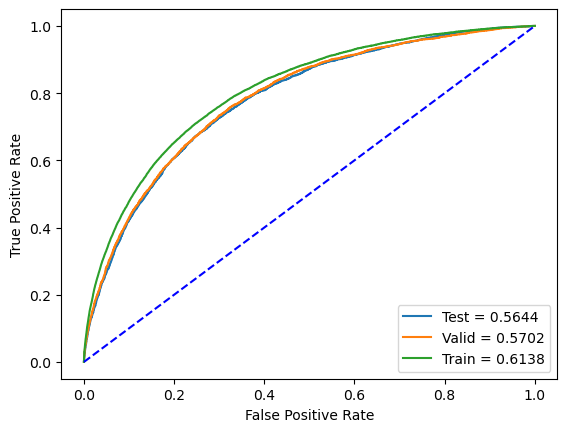

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = model_lgb_sw.predict(test_lgb[included])
pred_valid = model_lgb_sw.predict(valid_lgb[included])
pred_train = model_lgb_sw.predict(train_lgb[included])

plot_roc_curve(true_y = (test_lgb.TARGET, valid_lgb.TARGET, train_lgb.TARGET), 
               y_prob = (pred_test, pred_valid, pred_train))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

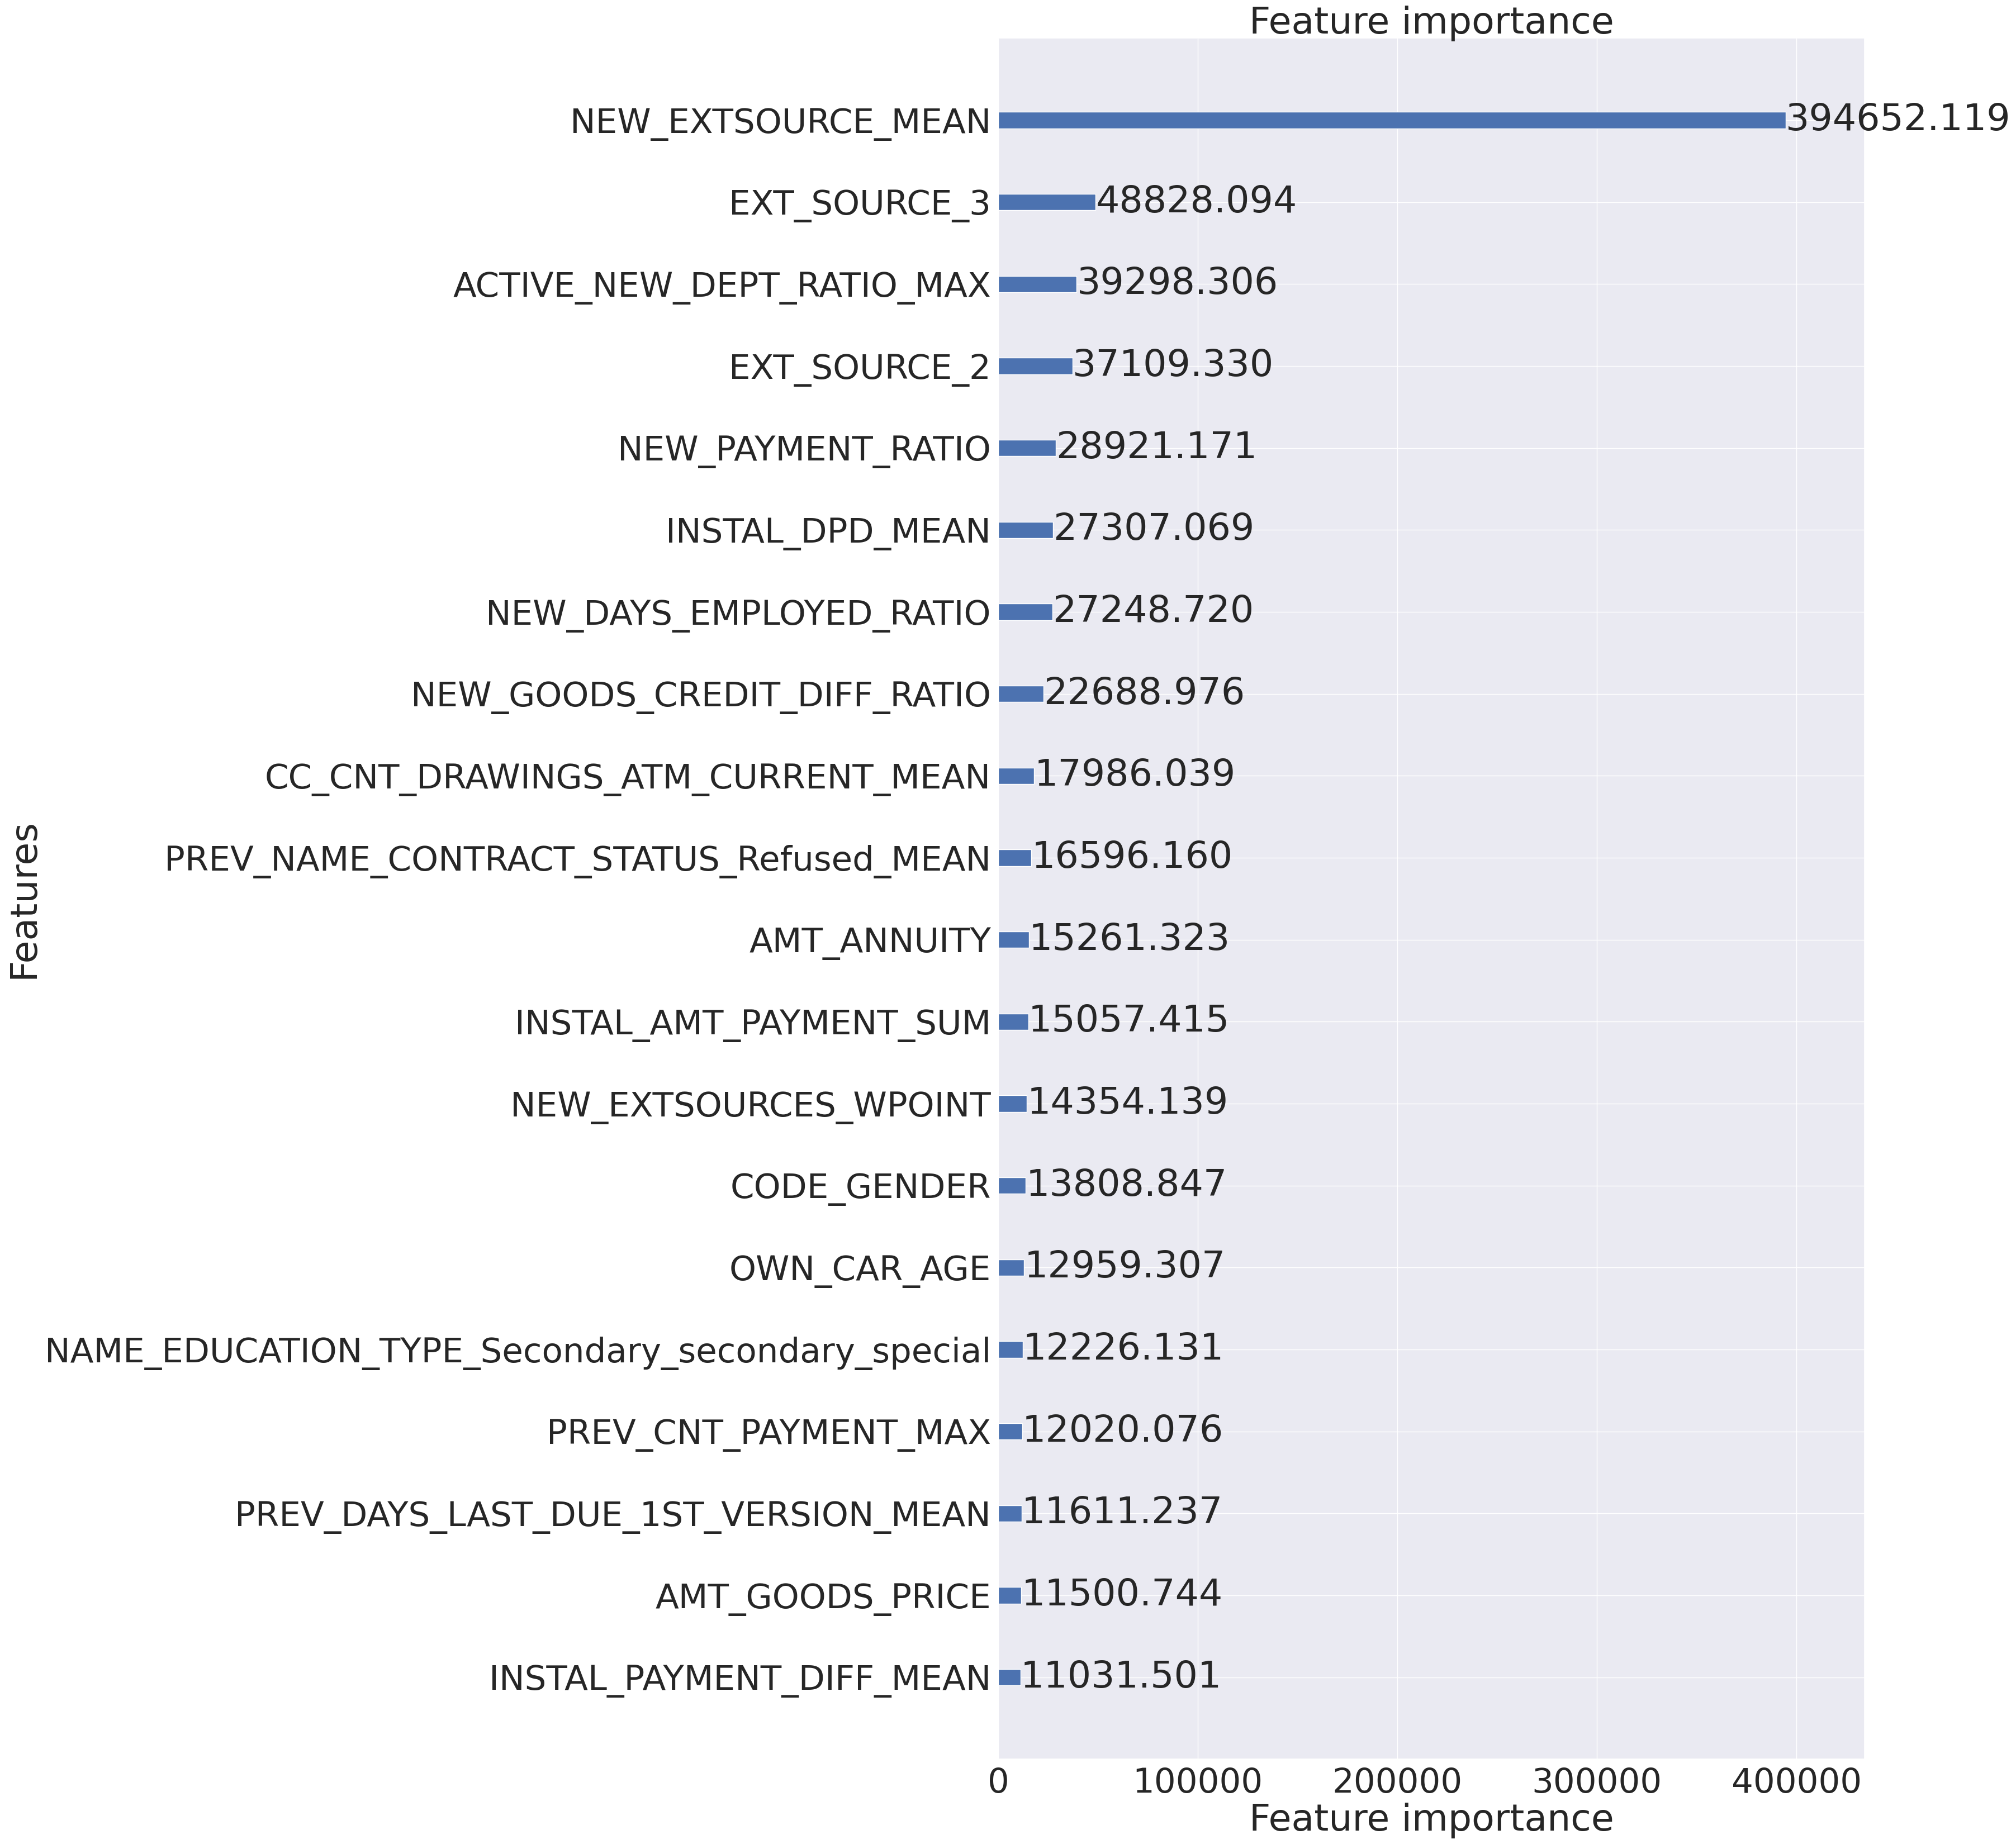

In [ ]:
lgb.plot_importance(model_lgb_sw, importance_type = 'gain', max_num_features = 20,
                   figsize = (20, 40))

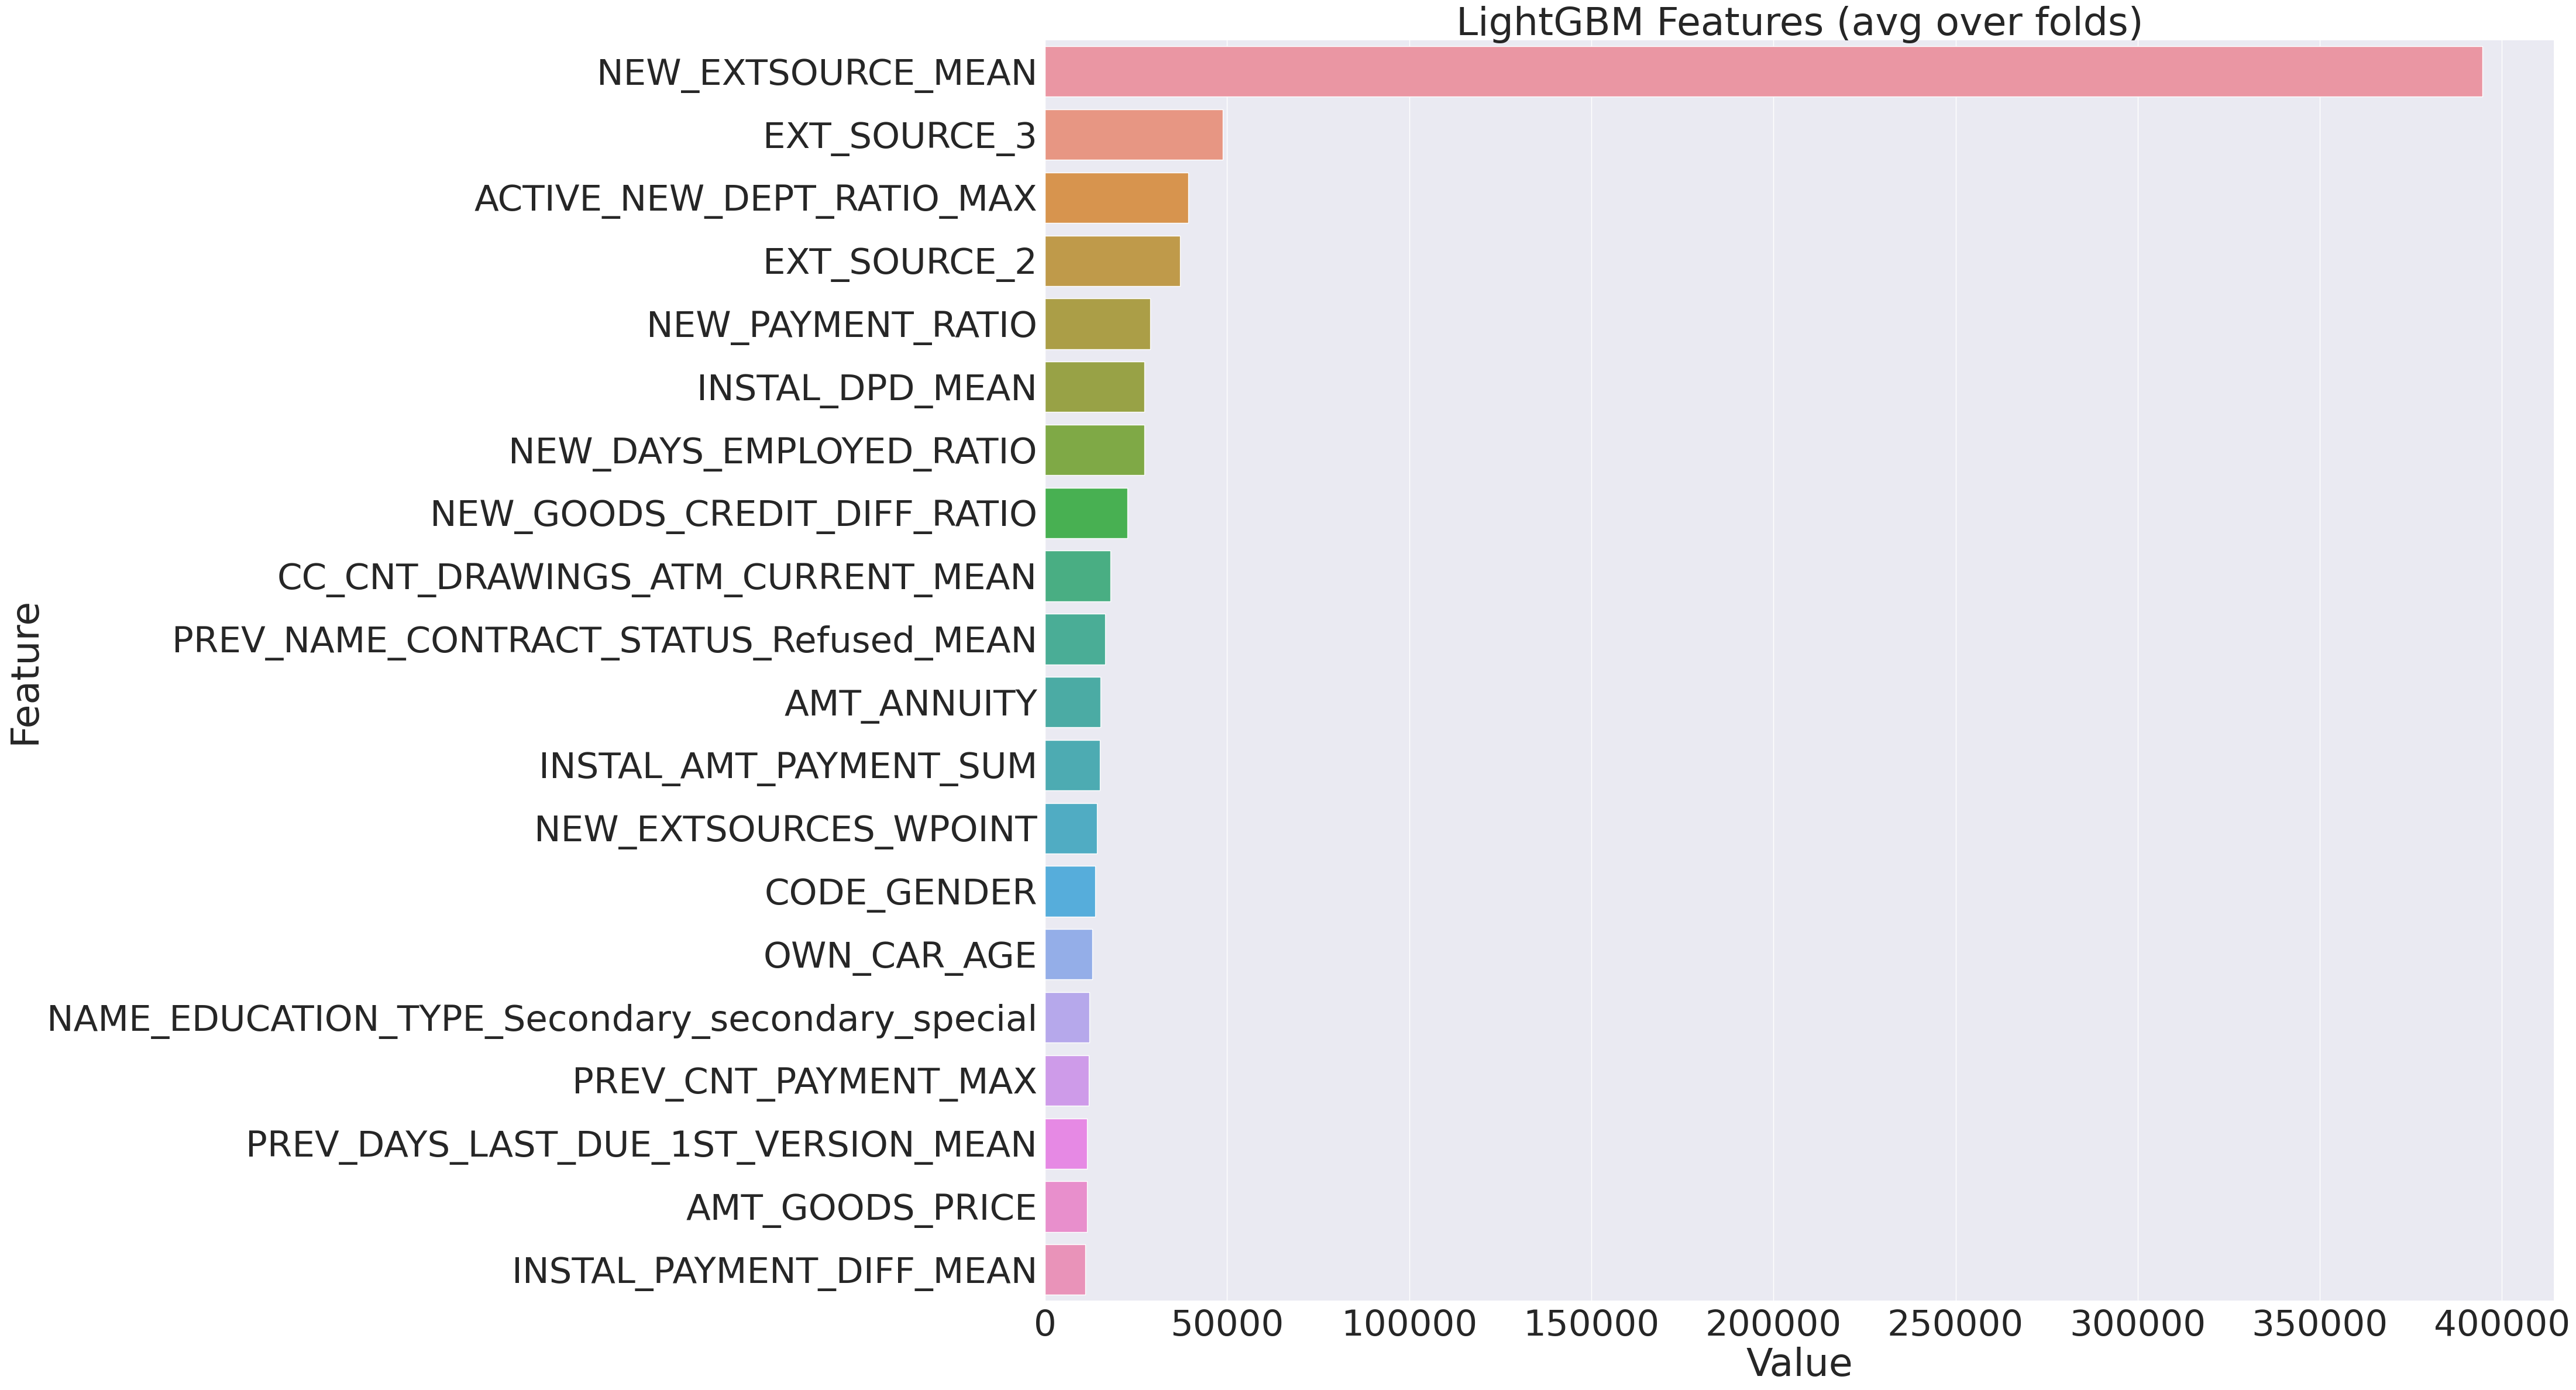

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model , num = 20, fig_size = (45, 25)):
#     print(len(model.feature_importance()))
#     print(len(X.columns))
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type = 'gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 4)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

plotImp(model = model_lgb_sw)

## Interpretability

# LOGIT + WOE Transformation

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
#     for ivars in ['AMT_REQ_CREDIT_BUREAU_YEAR']:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        
        # missing
        if d0.isnull().sum().sum() > 0 :
            try:
                d0['x'] = d0['x'].cat.add_categories('Missing')
                d0['x'].fillna('Missing', inplace =True)
            except:
#                 print('var ', ivars)
                d0['x'].fillna('Missing', inplace =True)

            
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events']) ## ln(good/bad) => event : good
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
#         print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [ ]:
newDF, woeDF = iv_woe(data = train.drop(columns = ['SK_ID_CURR']),
                        target = 'TARGET')

In [ ]:
newDF[newDF['IV']>= 0.02]

,Variable,IV
0,CODE_GENDER,0.042538
0,AMT_CREDIT,0.044389
0,AMT_ANNUITY,0.027077
0,AMT_GOODS_PRICE,0.089721
0,REGION_POPULATION_RELATIVE,0.033422
...,...,...
0,CLOSED_CNT_CREDIT_PROLONG_SUM,0.034479
0,CLOSED_MONTHS_BALANCE_SIZE_SUM,0.036922
0,CLOSED_NEW_DEPT_RATIO_MIN,0.028337
0,CLOSED_NEW_DEPT_RATIO_MAX,0.028716


In [ ]:
newDF[newDF['IV']>= 0.02].sort_values(by = 'IV', ascending = False).head(20)

,Variable,IV
0,NEW_EXTSOURCE_MEAN,0.618515
0,EXT_SOURCE_3,0.325841
0,EXT_SOURCE_2,0.314646
0,NEW_EXTSOURCES_WPOINT,0.266597
0,EXT_SOURCE_1,0.149939
0,BURO_NEW_DEPT_RATIO_MAX,0.142733
0,BURO_NEW_DEPT_RATIO_MEAN,0.133920
0,ACTIVE_NEW_DEPT_RATIO_MAX,0.120542
0,BURO_DAYS_CREDIT_MEAN,0.120113
0,DAYS_EMPLOYED,0.108743


In [ ]:
list(newDF[newDF['IV']>= 0.02].sort_values(by = 'IV', ascending = False).head(20)['Variable'])

['NEW_EXTSOURCE_MEAN',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'NEW_EXTSOURCES_WPOINT',
 'EXT_SOURCE_1',
 'BURO_NEW_DEPT_RATIO_MAX',
 'BURO_NEW_DEPT_RATIO_MEAN',
 'ACTIVE_NEW_DEPT_RATIO_MAX',
 'BURO_DAYS_CREDIT_MEAN',
 'DAYS_EMPLOYED',
 'NEW_PAYMENT_RATIO',
 'AMT_GOODS_PRICE',
 'BURO_NEWS_DAYS_CREDIT_UPDATE_new_MEAN',
 'BURO_CREDIT_ACTIVE_Active_MEAN',
 'BURO_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_NEWS_DAYS_CREDIT_UPDATE_old_MEAN',
 'NEW_DAYS_EMPLOYED_RATIO',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'ACTIVE_NEW_DEPT_RATIO_MEAN',
 'CLOSED_DAYS_CREDIT_MEAN']

In [ ]:
# chon bien co IV >= 0.02
woeDF[woeDF['Variable'].isin(newDF[newDF['IV']>= 0.02]['Variable'])]

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CODE_GENDER,0,71471,7170,0.425494,64301,0.334462,0.240727,0.021914
1,CODE_GENDER,1,137632,9681,0.574506,127951,0.665538,-0.147085,0.013389
0,AMT_CREDIT,"(44999.999, 180000.0]",22385,1478,0.087710,20907,0.108748,-0.214997,0.004523
1,AMT_CREDIT,"(180000.0, 254700.0]",21682,1666,0.098867,20016,0.104113,-0.051709,0.000271
2,AMT_CREDIT,"(254700.0, 306000.0]",18693,1579,0.093704,17114,0.089019,0.051292,0.000240
...,...,...,...,...,...,...,...,...,...
1,CLOSED_NEW_DEPT_RATIO_MAX,"(0.0, 281601.0]",3436,312,0.018515,3124,0.016250,0.130531,0.000296
2,CLOSED_NEW_DEPT_RATIO_MAX,Missing,60775,6125,0.363480,54650,0.284262,0.245827,0.019474
0,CLOSED_NEW_DEPT_RATIO_MEAN,"(-33981.166, 0.0]",144903,10415,0.618064,134488,0.699540,-0.123831,0.010089
1,CLOSED_NEW_DEPT_RATIO_MEAN,"(0.0, 247455.0]",3425,311,0.018456,3114,0.016197,0.130527,0.000295


In [ ]:
woeDF.shape

(3135, 9)

In [ ]:
transform_woe_df = woeDF[woeDF['Variable'].isin(newDF[newDF['IV']>= 0.02]['Variable'])]
transform_woe_df.shape

(3107, 9)

In [ ]:
transform_woe_df.head()

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CODE_GENDER,0,71471,7170,0.425494,64301,0.334462,0.240727,0.021914
1,CODE_GENDER,1,137632,9681,0.574506,127951,0.665538,-0.147085,0.013389
0,AMT_CREDIT,"(44999.999, 180000.0]",22385,1478,0.087710,20907,0.108748,-0.214997,0.004523
1,AMT_CREDIT,"(180000.0, 254700.0]",21682,1666,0.098867,20016,0.104113,-0.051709,0.000271
2,AMT_CREDIT,"(254700.0, 306000.0]",18693,1579,0.093704,17114,0.089019,0.051292,0.000240


In [ ]:
final_list = list(transform_woe_df['Variable'].unique())
print(len(final_list))
keep_cols = final_list + ['TARGET']
print(len(keep_cols))

358
359


In [ ]:
map_transform_dict = {}
for idx in range(transform_woe_df.shape[0]):
    var = transform_woe_df.iloc[idx]['Variable']
    cutoff = transform_woe_df.iloc[idx]['Cutoff']
    woe = float(transform_woe_df.iloc[idx]['WoE'])
    
    if var not in map_transform_dict:
        map_transform_dict[var] = [[], []]  ## cutoff, woe
    if str(cutoff) == 'Missing':
        map_transform_dict[var][0].append('Missing')
    elif '(' not in str(cutoff):
        map_transform_dict[var][0].append(cutoff)
    elif '(' in str(cutoff):
        cutoff_str = str(cutoff).replace('(', '').replace(']', '')
        upper = cutoff_str.split(',')[0]
        lower = cutoff_str.split(',')[-1]
        map_transform_dict[var][0].append([upper, lower])
    map_transform_dict[var][1].append(woe)

In [ ]:
from tqdm import tqdm
def map_woe_values(data, map_transform_dict):
    data = data.reset_index().drop(columns = ['index'])
    data_copy = copy.deepcopy(data)
    
    for var in tqdm(map_transform_dict.keys()):
#     for var in ['AMT_CREDIT', 'APPROVED_NEWX2_FLAG_AMT_CREDIT_RATIO_MIN']:
        try:
            cutoff_lst, woe_lst = map_transform_dict[var]
            for idx in range(len(cutoff_lst)):
                cutoff = cutoff_lst[idx]
                woe = woe_lst[idx]
                if type(cutoff) == int:
                    data[var] = data[var].replace({cutoff: woe})

                elif type(cutoff) == str:
                    if str(cutoff) != 'Missing':
                        data[var] = data[var].replace({cutoff: woe})
                    elif str(cutoff) == 'Missing':
                        data[var] = data[var].fillna(woe)
                elif type(cutoff) == float:
                    data[var] = data[var].map({cutoff: woe})

                elif len(cutoff) == 1:
                    if str(cutoff) != 'Missing':
                        data[var] = data[var].map({cutoff: woe})

                elif len(cutoff) == 2:
                    upper = float(cutoff[0])
                    lower = float(cutoff[-1])
                    index_ = data_copy[(data_copy[var]> upper)&
                                       (data_copy[var]<= lower)].index
                    data.iloc[index_, data.columns.get_loc(var)] = woe
        except:
            print('FAIL ', var)
                
    return data, data_copy

In [ ]:
train_w = train[keep_cols].reset_index().drop(columns = ['index'])
train_temp = copy.deepcopy(train_w)
train_map, train_copy = map_woe_values(data = train_temp, map_transform_dict = map_transform_dict)
train_map.head()

100%|██████████| 358/358 [02:17<00:00,  2.60it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_SIZE_SUM,CLOSED_NEW_DEPT_RATIO_MIN,CLOSED_NEW_DEPT_RATIO_MAX,CLOSED_NEW_DEPT_RATIO_MEAN,TARGET
0,-0.147085,0.293533,0.044493,-0.253641,0.146766,0.130601,-0.628970,0.058837,-0.339410,0.092165,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0
1,0.240727,-0.051709,-0.176538,-0.025711,-0.057043,0.326006,-0.098029,0.088146,0.109559,-0.088177,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0
2,0.240727,-0.449833,-0.038001,-0.560476,0.008725,0.187247,-0.355229,0.202957,-0.339410,0.092165,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0
3,-0.147085,0.179557,-0.382070,-0.253641,0.186231,-0.029352,-0.628970,0.075300,0.244650,0.064099,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0
4,-0.147085,-0.051709,-0.176538,-0.025711,-0.057043,-0.029352,0.386160,0.202957,0.244650,-0.278294,...,0.291126,0.291126,0.213349,0.291126,0.291126,0.291126,0.245827,0.245827,0.245827,0


In [ ]:
valid_w = valid[keep_cols].reset_index().drop(columns = ['index'])
valid_temp = copy.deepcopy(valid_w)
valid_map, valid_copy = map_woe_values(data = valid_temp, map_transform_dict = map_transform_dict)
valid_map.head()

100%|██████████| 358/358 [00:44<00:00,  7.99it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_SIZE_SUM,CLOSED_NEW_DEPT_RATIO_MIN,CLOSED_NEW_DEPT_RATIO_MAX,CLOSED_NEW_DEPT_RATIO_MEAN,TARGET
0,0.240727,0.061245,0.065149,0.046498,-0.048126,-0.029352,-0.628970,0.058837,0.244650,0.064099,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0
1,-0.147085,-0.148047,-0.038001,-0.207117,-0.175480,-0.128289,0.319901,-0.230359,0.218982,0.064099,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0
2,-0.147085,0.252602,0.108601,0.226927,-0.057043,0.326006,0.198797,0.088146,-0.059519,-0.489441,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.273243,-0.118315,-0.123853,-0.123831,0
3,0.240727,0.061245,0.065149,0.046498,0.072508,0.187247,0.319901,0.088146,0.109559,-0.489441,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0
4,-0.147085,0.051292,0.108601,-0.025711,0.008725,0.130601,-0.628970,-0.358693,-0.048124,0.064099,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0


In [ ]:
test_w = test[keep_cols].reset_index().drop(columns = ['index'])
test_temp = copy.deepcopy(test_w)
test_map, test_copy = map_woe_values(data = test_temp, map_transform_dict = map_transform_dict)
test_map.head()

100%|██████████| 358/358 [00:30<00:00, 11.81it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_SIZE_SUM,CLOSED_NEW_DEPT_RATIO_MIN,CLOSED_NEW_DEPT_RATIO_MAX,CLOSED_NEW_DEPT_RATIO_MEAN,TARGET
0,0.240727,-0.214997,-0.142838,-0.120321,0.167966,0.187247,0.386160,-0.012377,-0.204711,0.064099,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0
1,-0.147085,0.179557,0.108601,0.562836,0.004033,0.384110,0.356596,0.202957,0.155322,0.064099,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,1
2,-0.147085,-0.179275,-0.382070,-0.207117,0.008725,-0.262378,-0.355229,-0.358693,-0.059519,0.064099,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0
3,-0.147085,0.051292,0.015793,-0.025711,0.146766,0.187247,0.269424,-0.012377,-0.289215,0.064099,...,-0.122581,-0.116458,0.213349,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0
4,-0.147085,0.293533,0.044493,-0.253641,0.167966,-0.029352,-0.355229,-0.012377,0.244650,0.064099,...,-0.122581,-0.116458,-0.136615,-0.117595,0.291126,-0.120293,-0.118315,-0.123853,-0.123831,0


In [ ]:
train_map.isnull().sum().sum(), valid_map.isnull().sum().sum(), test_map.isnull().sum().sum()

(0, 0, 0)

In [ ]:
train_map_w = train_map[np.isfinite(train_map).all(1)]
valid_map_w = valid_map[np.isfinite(valid_map).all(1)]
test_map_w  = test_map[np.isfinite(test_map).all(1)]

## LOGIT + fullvars

In [ ]:
log_reg_w = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg_w.fit(train_map_w.drop(['TARGET'],axis=1), train_map_w['TARGET'])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=0.0001)

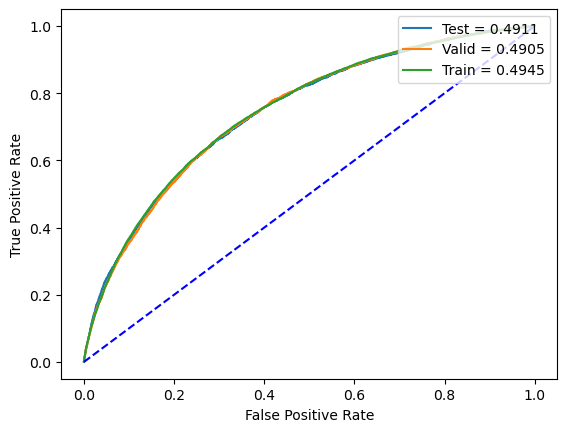

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=1)
    

pred_test = log_reg_w.predict_proba(test_map_w.drop(['TARGET'],axis=1))[:, 1]
pred_valid = log_reg_w.predict_proba(valid_map_w.drop(['TARGET'],axis=1))[:, 1]
pred_train = log_reg_w.predict_proba(train_map_w.drop(['TARGET'],axis=1))[:, 1]

plot_roc_curve(true_y = (test_map_w['TARGET'], valid_map_w['TARGET'], train_map_w['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
log_reg_w.coef_

array([[ 3.81934438e-02,  3.22916915e-02,  2.38262516e-02,
         6.63588367e-02,  2.67822891e-03,  4.06241785e-02,
         7.05908367e-02,  1.70928434e-02,  2.06497130e-02,
         2.20734753e-02,  3.29723650e-02,  3.54250899e-02,
         8.42151823e-02,  1.77378081e-01,  1.70444040e-01,
         1.48591085e-02,  9.12312997e-03,  1.53159977e-02,
         1.50097778e-02,  1.30698302e-02,  2.74789135e-02,
         4.94951963e-02,  1.52895886e-02,  8.09218096e-03,
         1.51189583e-02,  8.40536144e-03,  1.41097477e-02,
         1.56676164e-02,  1.04344178e-02,  3.09221330e-02,
         1.44432922e-02,  7.74026626e-03,  1.51296749e-02,
         8.98716832e-03,  1.58094559e-02,  1.36644873e-02,
         1.22586701e-02,  2.93587715e-02,  6.48495537e-02,
         1.49329047e-02,  8.11577133e-03,  1.78949410e-02,
         2.74779044e-02,  1.59604410e-02,  2.48758046e-02,
         6.06362901e-02,  7.24775595e-02,  3.32580377e-01,
         1.42699573e-01,  6.54506824e-02,  3.68529529e-0

## LOGIT + selected feature by gini

In [ ]:
selected_feature = list(newDF[newDF['IV']>= 0.02].sort_values(by = 'IV', ascending = False).head(20)['Variable'])
len(selected_feature), selected_feature

(20,
 ['NEW_EXTSOURCE_MEAN',
  'EXT_SOURCE_3',
  'EXT_SOURCE_2',
  'NEW_EXTSOURCES_WPOINT',
  'EXT_SOURCE_1',
  'BURO_NEW_DEPT_RATIO_MAX',
  'BURO_NEW_DEPT_RATIO_MEAN',
  'ACTIVE_NEW_DEPT_RATIO_MAX',
  'BURO_DAYS_CREDIT_MEAN',
  'DAYS_EMPLOYED',
  'NEW_PAYMENT_RATIO',
  'AMT_GOODS_PRICE',
  'BURO_NEWS_DAYS_CREDIT_UPDATE_new_MEAN',
  'BURO_CREDIT_ACTIVE_Active_MEAN',
  'BURO_DAYS_CREDIT_UPDATE_MEAN',
  'BURO_NEWS_DAYS_CREDIT_UPDATE_old_MEAN',
  'NEW_DAYS_EMPLOYED_RATIO',
  'BURO_CREDIT_ACTIVE_Closed_MEAN',
  'ACTIVE_NEW_DEPT_RATIO_MEAN',
  'CLOSED_DAYS_CREDIT_MEAN'])

In [ ]:
log_reg_gini = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg_gini.fit(train_map_w[selected_feature], train_map_w['TARGET'])

LogisticRegression(C=0.0001)

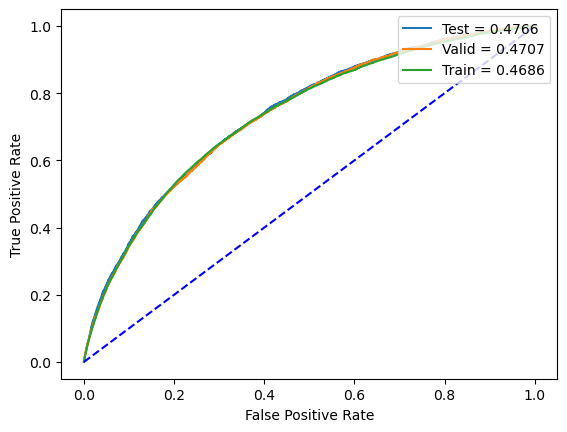

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=1)
    

pred_test = log_reg_gini.predict_proba(test_map_w[selected_feature])[:, 1]
pred_valid = log_reg_gini.predict_proba(valid_map_w[selected_feature])[:, 1]
pred_train = log_reg_gini.predict_proba(train_map_w[selected_feature])[:, 1]

plot_roc_curve(true_y = (test_map_w['TARGET'], valid_map_w['TARGET'], train_map_w['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

## LOGIT + stepwise_selection

In [ ]:
import pandas as pd
import statsmodels.api as sm

In [ ]:
def backward_regression(X, y,
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {} with p-value = {}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

included = backward_regression(train_map_w.drop(columns = ['TARGET']), train_map_w['TARGET'])

Drop APPROVED_NEW_AMT_CREDIT_RATIO_MEDIAN with p-value = 0.9962924527406611
Drop REFUSED_NEW_GOODS_RATIO_MEDIAN with p-value = 0.9955430105736246
Drop CC_CNT_INSTALMENT_MATURE_CUM_MEAN with p-value = 0.9943202949687089
Drop CC_AMT_DRAWINGS_POS_CURRENT_VAR with p-value = 0.9847349567436783
Drop APPROVED_AMT_APPLICATION_MAX with p-value = 0.9830490379246557
Drop PREV_NAME_YIELD_GROUP_low_normal_MEAN with p-value = 0.9798359072604835
Drop INSTAL_AMT_PAYMENT_MAX with p-value = 0.9755087150583991
Drop APPROVED_AMT_DOWN_PAYMENT_MEAN with p-value = 0.9754599805129445
Drop PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN with p-value = 0.965408677899224
Drop PREV_PRODUCT_COMBINATION_Card Street_MEAN with p-value = 0.9600298301094417
Drop CC_AMT_DRAWINGS_POS_CURRENT_MAX with p-value = 0.9598068753480398
Drop INSTAL_DAYS_ENTRY_PAYMENT_MEAN with p-value = 0.9519086997861548
Drop BURO_AMT_CREDIT_SUM_DEBT_MEAN with p-value = 0.9446782545235686
Drop BASEMENTAREA_MODE with p-value = 0.9438214

In [ ]:
len(included), included

(143,
 ['CODE_GENDER',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'DAYS_REGISTRATION',
  'DAYS_ID_PUBLISH',
  'OWN_CAR_AGE',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'YEARS_BEGINEXPLUATATION_AVG',
  'APARTMENTS_MODE',
  'YEARS_BEGINEXPLUATATION_MEDI',
  'ELEVATORS_MEDI',
  'DAYS_LAST_PHONE_CHANGE',
  'NEW_DOCUMENT',
  'NEW_DAYS_EMPLOYED_RATIO',
  'NEW_PAYMENT_RATIO',
  'NEW_EXTSOURCE_MEAN',
  'NEW_EXTSOURCES_WPOINT',
  'NEW_GOODS_CREDIT_DIFF_RATIO',
  'NAME_INCOME_TYPE_Working',
  'NAME_EDUCATION_TYPE_Secondary_secondary_special',
  'OCCUPATION_TYPE_Laborers',
  'ORGANIZATION_TYPE_XNA',
  'NEW_SEGMENT_AGE_Old',
  'NEW_SEGMENT_AGE_Young',
  'POS_MONTHS_BALANCE_SIZE_Cfull',
  'POS_COUNT',
  'INSTAL_DPD_MEAN',
  'INSTAL_PAYMENT_DIFF_MAX',
  'INSTAL_PAYMENT_DIFF_MEAN',
  'INSTAL_AMT_INSTALMENT_MAX',
  'INSTAL_AMT_INSTALMENT_MEAN',
  'INSTAL_AMT_INSTALMENT_SUM',
  'INSTAL_AMT_PAYMENT_MEAN',
  'INSTAL_AMT_

In [ ]:
log_reg_sm.coef_

array([[ 4.55569504e-02,  3.61255690e-02,  2.80407721e-02,
         7.75609217e-02,  2.01483993e-02,  2.52455709e-02,
         2.60223574e-02,  3.40494841e-02,  3.77639277e-02,
         8.02975907e-02,  1.67288253e-01,  1.74058397e-01,
         2.17477223e-02,  2.61984422e-02,  2.21961117e-02,
         2.30494546e-02,  3.10089020e-02,  3.04913267e-02,
         7.50971993e-02,  7.86789515e-02,  3.19157056e-01,
         1.25238051e-01,  4.84060252e-02,  3.97499909e-02,
         3.91112038e-02,  2.26701495e-02,  2.45280121e-02,
         3.82600431e-02,  1.81158546e-02,  2.63710010e-02,
         2.63710010e-02,  4.92616332e-02,  2.71623866e-02,
         4.23505449e-02,  3.52407780e-02,  1.78892082e-02,
         2.20321240e-02,  2.63458989e-02,  2.93228282e-02,
         1.52386647e-02,  1.38964718e-02,  2.04399816e-02,
         1.51766996e-02,  2.30217622e-02,  1.66404575e-02,
         1.29054509e-02,  2.27100102e-02,  2.75694984e-02,
         2.07213466e-02,  3.40568490e-02,  3.67355316e-0

In [ ]:
included = ['CODE_GENDER',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'DAYS_REGISTRATION',
  'DAYS_ID_PUBLISH',
  'OWN_CAR_AGE',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'YEARS_BEGINEXPLUATATION_AVG',
  'APARTMENTS_MODE',
  'YEARS_BEGINEXPLUATATION_MEDI',
  'ELEVATORS_MEDI',
  'DAYS_LAST_PHONE_CHANGE',
  'NEW_DOCUMENT',
  'NEW_DAYS_EMPLOYED_RATIO',
  'NEW_PAYMENT_RATIO',
  'NEW_EXTSOURCE_MEAN',
  'NEW_EXTSOURCES_WPOINT',
  'NEW_GOODS_CREDIT_DIFF_RATIO',
  'NAME_INCOME_TYPE_Working',
  'NAME_EDUCATION_TYPE_Secondary_secondary_special',
  'OCCUPATION_TYPE_Laborers',
  'ORGANIZATION_TYPE_XNA',
  'NEW_SEGMENT_AGE_Old',
  'NEW_SEGMENT_AGE_Young',
  'POS_MONTHS_BALANCE_SIZE_Cfull',
  'POS_COUNT',
  'INSTAL_DPD_MEAN',
  'INSTAL_PAYMENT_DIFF_MAX',
  'INSTAL_PAYMENT_DIFF_MEAN',
  'INSTAL_AMT_INSTALMENT_MAX',
  'INSTAL_AMT_INSTALMENT_MEAN',
  'INSTAL_AMT_INSTALMENT_SUM',
  'INSTAL_AMT_PAYMENT_MEAN',
  'INSTAL_AMT_PAYMENT_SUM',
  'PREV_AMT_ANNUITY_MIN',
  'PREV_AMT_ANNUITY_MEAN',
  'PREV_AMT_DOWN_PAYMENT_MEDIAN',
  'PREV_HOUR_APPR_PROCESS_START_MEAN',
  'PREV_CNT_PAYMENT_MAX',
  'PREV_DAYS_FIRST_DUE_MEAN',
  'PREV_DAYS_FIRST_DUE_MEDIAN',
  'PREV_DAYS_LAST_DUE_1ST_VERSION_MIN',
  'PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN',
  'PREV_DAYS_LAST_DUE_MIN',
  'PREV_NEW_AMT_CREDIT_RATIO_MAX',
  'PREV_NEW_AMT_CREDIT_RATIO_MEAN',
  'PREV_NEW_AMT_CREDIT_RATIO_MEDIAN',
  'PREV_NEW_INSURED_ON_APPROVAL_MEAN',
  'PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN',
  'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
  'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
  'PREV_NAME_YIELD_GROUP_high_MEAN',
  'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN',
  'PREV_NEW_FLAG_LATE_DAYS_NaN_MEAN',
  'APPROVED_AMT_ANNUITY_MEDIAN',
  'APPROVED_AMT_APPLICATION_MEDIAN',
  'APPROVED_AMT_CREDIT_MEAN',
  'APPROVED_AMT_GOODS_PRICE_MAX',
  'APPROVED_AMT_GOODS_PRICE_MEDIAN',
  'APPROVED_HOUR_APPR_PROCESS_START_MAX',
  'APPROVED_RATE_DOWN_PAYMENT_MAX',
  'APPROVED_DAYS_DECISION_MEDIAN',
  'APPROVED_DAYS_FIRST_DUE_MEAN',
  'APPROVED_DAYS_FIRST_DUE_MEDIAN',
  'APPROVED_DAYS_LAST_DUE_1ST_VERSION_MIN',
  'APPROVED_DAYS_LAST_DUE_1ST_VERSION_MEAN',
  'APPROVED_DAYS_LAST_DUE_MIN',
  'APPROVED_NEWX2_FLAG_AMT_CREDIT_RATIO_MIN',
  'APPROVED_NEWX2_FLAG_AMT_CREDIT_RATIO_MEAN',
  'REFUSED_AMT_ANNUITY_MAX',
  'REFUSED_AMT_CREDIT_MIN',
  'REFUSED_AMT_CREDIT_MEAN',
  'REFUSED_AMT_GOODS_PRICE_MEAN',
  'REFUSED_HOUR_APPR_PROCESS_START_MIN',
  'REFUSED_DAYS_DECISION_MEAN',
  'REFUSED_CNT_PAYMENT_MAX',
  'REFUSED_CNT_PAYMENT_MEAN',
  'REFUSED_CNT_PAYMENT_MEDIAN',
  'REFUSED_NEW_AMT_CREDIT_RATIO_MEAN',
  'REFUSED_NEWX2_FLAG_AMT_CREDIT_RATIO_MIN',
  'REFUSED_NEWX2_FLAG_AMT_CREDIT_RATIO_MAX',
  'REFUSED_NEWX2_FLAG_AMT_CREDIT_RATIO_MEAN',
  'REFUSED_NEWX2_FLAG_AMT_CREDIT_RATIO_MEDIAN',
  'REFUSED_NEW_INSURED_ON_APPROVAL_MIN',
  'REFUSED_NEW_INSURED_ON_APPROVAL_MAX',
  'REFUSED_NEW_INSURED_ON_APPROVAL_MEAN',
  'REFUSED_NEW_INSURED_ON_APPROVAL_MEDIAN',
  'REFUSED_NEW_HOW_PAID_YEARS_MIN',
  'REFUSED_WEEKDAY_APPR_PROCESS_START_DIC_MIN',
  'REFUSED_WEEKDAY_APPR_PROCESS_START_DIC_MAX',
  'REFUSED_WEEKDAY_APPR_PROCESS_START_DIC_MEAN',
  'REFUSED_WEEKDAY_APPR_PROCESS_START_DIC_MEDIAN',
  'REFUSED_NEW_WEEKDAY_SIN_MIN',
  'REFUSED_NEW_WEEKDAY_SIN_MAX',
  'REFUSED_NEW_WEEKDAY_SIN_MEDIAN',
  'REFUSED_NEW_WEEKDAY_COS_MIN',
  'REFUSED_NEW_WEEKDAY_COS_MAX',
  'CC_AMT_BALANCE_MIN',
  'CC_AMT_DRAWINGS_CURRENT_SUM',
  'CC_AMT_DRAWINGS_POS_CURRENT_MEAN',
  'CC_AMT_PAYMENT_CURRENT_MIN',
  'CC_AMT_PAYMENT_CURRENT_SUM',
  'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN',
  'CC_AMT_RECEIVABLE_PRINCIPAL_MIN',
  'CC_AMT_RECIVABLE_MIN',
  'CC_AMT_TOTAL_RECEIVABLE_MIN',
  'CC_CNT_DRAWINGS_ATM_CURRENT_MAX',
  'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
  'CC_CNT_DRAWINGS_ATM_CURRENT_SUM',
  'CC_CNT_DRAWINGS_ATM_CURRENT_VAR',
  'CC_CNT_DRAWINGS_CURRENT_MAX',
  'CC_CNT_DRAWINGS_CURRENT_SUM',
  'CC_CNT_DRAWINGS_POS_CURRENT_MEAN',
  'CC_TOTAL_SPENDING_SUM',
  'BURO_DAYS_CREDIT_MIN',
  'BURO_DAYS_CREDIT_MEAN',
  'BURO_DAYS_CREDIT_VAR',
  'BURO_DAYS_CREDIT_ENDDATE_MAX',
  'BURO_DAYS_ENDDATE_FACT_MIN',
  'BURO_DAYS_ENDDATE_FACT_MAX',
  'BURO_DAYS_ENDDATE_FACT_MEAN',
  'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
  'BURO_AMT_CREDIT_SUM_MAX',
  'BURO_AMT_CREDIT_SUM_DEBT_MAX',
  'BURO_NEW_DEPT_RATIO_MIN',
  'BURO_CREDIT_ACTIVE_Active_MEAN',
  'BURO_NEWS_DAYS_CREDIT_UPDATE_new_MEAN',
  'BURO_NEWS_DAYS_CREDIT_UPDATE_old_MEAN',
  'ACTIVE_DAYS_CREDIT_MAX',
  'ACTIVE_DAYS_CREDIT_VAR',
  'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
  'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN',
  'ACTIVE_NEW_DEPT_RATIO_MIN',
  'ACTIVE_NEW_DEPT_RATIO_MAX',
  'CLOSED_DAYS_CREDIT_MAX',
  'CLOSED_DAYS_ENDDATE_FACT_MIN',
  'CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN']

log_reg_sm = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg_sm.fit(train_map_w[included], train_map_w['TARGET'])

LogisticRegression(C=0.0001)

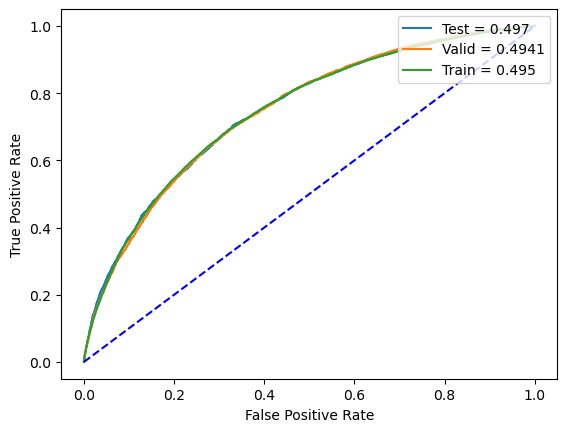

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=1)
    

pred_test = log_reg_sm.predict_proba(test_map_w[included])[:, 1]
pred_valid = log_reg_sm.predict_proba(valid_map_w[included])[:, 1]
pred_train = log_reg_sm.predict_proba(train_map_w[included])[:, 1]

plot_roc_curve(true_y = (test_map_w['TARGET'], valid_map_w['TARGET'], train_map_w['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
log_reg_sm.coef_

array([[4.55568291e-02, 3.61249101e-02, 2.80406304e-02, 7.75603499e-02,
        2.01482290e-02, 2.52451774e-02, 2.60224187e-02, 3.40485575e-02,
        3.77630686e-02, 8.02951149e-02, 1.67282362e-01, 1.74055503e-01,
        2.17472256e-02, 2.61979863e-02, 2.21956326e-02, 2.30488650e-02,
        3.10075452e-02, 3.04916028e-02, 7.50960098e-02, 7.86782700e-02,
        3.19147288e-01, 1.25234041e-01, 4.84060714e-02, 3.97493867e-02,
        3.91110492e-02, 2.26699240e-02, 2.45273700e-02, 3.82594230e-02,
        1.81148036e-02, 2.63698612e-02, 2.63698612e-02, 4.92622015e-02,
        2.71625739e-02, 4.23506186e-02, 3.52404193e-02, 1.78886185e-02,
        2.20311504e-02, 2.63453355e-02, 2.93218454e-02, 1.52390626e-02,
        1.38957313e-02, 2.04400062e-02, 1.51763532e-02, 2.30227348e-02,
        1.66389764e-02, 1.29043371e-02, 2.27084039e-02, 2.75687699e-02,
        2.07200720e-02, 3.40557784e-02, 3.67358034e-02, 3.90270388e-02,
        1.15618069e-02, 1.09103866e-02, 4.66383843e-02, 3.354503

In [ ]:
log_reg_sm.intercept_

array([-2.3438397])

## Interpretability

### Model coef

In [ ]:
import matplotlib.pyplot as plt 
coef = log_reg_sm.coef_[0]

In [ ]:
len(coef)

142

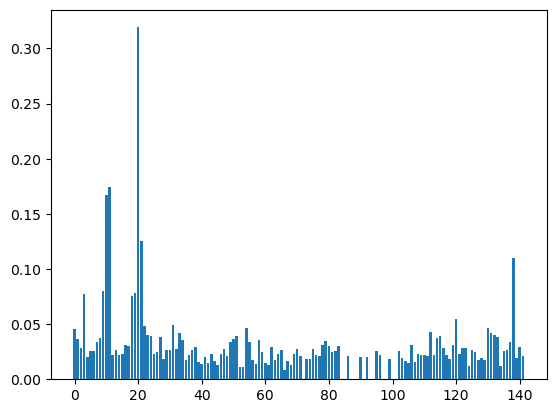

In [ ]:
plt.bar([x for x in range(len(coef))], coef)
# plt.xticks([x for x in range(len(coef))], included, rotation = 30)
# plt.rc('font', size = 30)
# plt.rc('xtick', labelsize = 30)
plt.show()

### Variables

In [ ]:
woeDF.head()

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CODE_GENDER,0,71337,7270,0.433176,64067,0.333127,0.262621,0.026275
1,CODE_GENDER,1,137766,9513,0.566824,128253,0.666873,-0.162551,0.016263
0,AMT_CREDIT,"(44999.999, 180000.0]",22656,1523,0.090747,21133,0.109885,-0.191360,0.003662
1,AMT_CREDIT,"(180000.0, 254700.0]",21553,1665,0.099208,19888,0.103411,-0.041497,0.000174
2,AMT_CREDIT,"(254700.0, 306000.0]",18589,1519,0.090508,17070,0.088758,0.019524,0.000034


In [ ]:
df_included = woeDF[woeDF['Variable'].isin(included)]
print(df_included.shape)
df_included.head()

(1187, 9)


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CODE_GENDER,0,71337,7270,0.433176,64067,0.333127,0.262621,0.026275
1,CODE_GENDER,1,137766,9513,0.566824,128253,0.666873,-0.162551,0.016263
0,AMT_CREDIT,"(44999.999, 180000.0]",22656,1523,0.090747,21133,0.109885,-0.191360,0.003662
1,AMT_CREDIT,"(180000.0, 254700.0]",21553,1665,0.099208,19888,0.103411,-0.041497,0.000174
2,AMT_CREDIT,"(254700.0, 306000.0]",18589,1519,0.090508,17070,0.088758,0.019524,0.000034


In [ ]:
7192 + 64390

71582

In [ ]:
dat['TARGET'].value_counts()

0    282680
1     24825
Name: TARGET, dtype: int64

In [ ]:
newDF.sort_values(by = 'IV', ascending = False).head(20)

,Variable,IV
0,NEW_EXTSOURCE_MEAN,0.597736
0,EXT_SOURCE_3,0.331556
0,EXT_SOURCE_2,0.299635
0,NEW_EXTSOURCES_WPOINT,0.271148
0,EXT_SOURCE_1,0.154664
0,BURO_NEW_DEPT_RATIO_MAX,0.145240
0,BURO_NEW_DEPT_RATIO_MEAN,0.136744
0,ACTIVE_NEW_DEPT_RATIO_MAX,0.125368
0,BURO_DAYS_CREDIT_MEAN,0.123019
0,DAYS_EMPLOYED,0.113084


#### Select features

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
newDF.sort_values(by = 'IV', ascending = False).head(10)

,Variable,IV
0,NEW_EXTSOURCE_MEAN,0.597736
0,EXT_SOURCE_3,0.331556
0,EXT_SOURCE_2,0.299635
0,NEW_EXTSOURCES_WPOINT,0.271148
0,EXT_SOURCE_1,0.154664
0,BURO_NEW_DEPT_RATIO_MAX,0.145240
0,BURO_NEW_DEPT_RATIO_MEAN,0.136744
0,ACTIVE_NEW_DEPT_RATIO_MAX,0.125368
0,BURO_DAYS_CREDIT_MEAN,0.123019
0,DAYS_EMPLOYED,0.113084


In [ ]:
0    282680 : GOOD
1     24825 : BAD

#### NEW_EXTSOURCE_MEAN

In [ ]:
# application_train
# df["NEW_EXTSOURCE_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
# NEW_EXTSOURCE_MEAN
df_included[df_included['Variable'] == 'NEW_EXTSOURCE_MEAN']

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,NEW_EXTSOURCE_MEAN,"(-0.00099406, 0.304]",20899,4749,0.282965,16150,0.083975,1.214808,2.417350e-01
1,NEW_EXTSOURCE_MEAN,"(0.304, 0.385]",20899,3018,0.179825,17881,0.092975,0.659650,5.729031e-02
2,NEW_EXTSOURCE_MEAN,"(0.385, 0.44]",20899,2149,0.128046,18750,0.097494,0.272603,8.328698e-03
3,NEW_EXTSOURCE_MEAN,"(0.44, 0.484]",20898,1673,0.099684,19225,0.099964,-0.002799,7.820104e-07
4,NEW_EXTSOURCE_MEAN,"(0.484, 0.525]",20899,1359,0.080975,19540,0.101601,-0.226920,4.680618e-03
5,NEW_EXTSOURCE_MEAN,"(0.525, 0.564]",20899,1109,0.066079,19790,0.102901,-0.442924,1.630963e-02
6,NEW_EXTSOURCE_MEAN,"(0.564, 0.603]",20898,892,0.053149,20006,0.104025,-0.671527,3.416430e-02
7,NEW_EXTSOURCE_MEAN,"(0.603, 0.644]",20899,798,0.047548,20101,0.104519,-0.787622,4.487114e-02
8,NEW_EXTSOURCE_MEAN,"(0.644, 0.692]",20899,598,0.035631,20301,0.105558,-1.086040,7.594372e-02
9,NEW_EXTSOURCE_MEAN,"(0.692, 0.864]",20899,433,0.025800,20466,0.106416,-1.416988,1.142326e-01


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


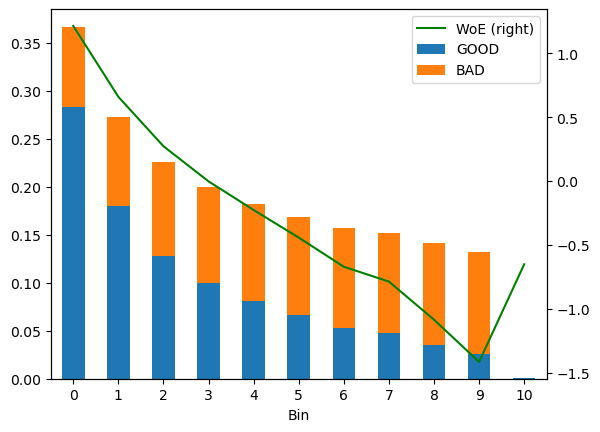

In [ ]:
temp = df_included[df_included['Variable'] == 'NEW_EXTSOURCE_MEAN']
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
# 10 la missing : chi co 115 obs => nhom vao nhom cuoi cung

In [ ]:
update_temp1 = temp[['Variable', 'Cutoff', 'N', 'Events', 'Non-Events', 'Bin']]

,Variable,Cutoff,N,Events,Non-Events,Bin
0,NEW_EXTSOURCE_MEAN,"(-0.00099406, 0.304]",20899,4749,16150,0
1,NEW_EXTSOURCE_MEAN,"(0.304, 0.385]",20899,3018,17881,1
2,NEW_EXTSOURCE_MEAN,"(0.385, 0.44]",20899,2149,18750,2
3,NEW_EXTSOURCE_MEAN,"(0.44, 0.484]",20898,1673,19225,3
4,NEW_EXTSOURCE_MEAN,"(0.484, 0.525]",20899,1359,19540,4
5,NEW_EXTSOURCE_MEAN,"(0.525, 0.564]",20899,1109,19790,5
6,NEW_EXTSOURCE_MEAN,"(0.564, 0.603]",20898,892,20006,6
7,NEW_EXTSOURCE_MEAN,"(0.603, 0.644]",20899,798,20101,7
8,NEW_EXTSOURCE_MEAN,"(0.644, 0.692]",20899,598,20301,8
9,NEW_EXTSOURCE_MEAN,"(0.692, 0.864]",20899,433,20466,9


In [ ]:
update_temp1.loc[11, 'Variable'] = 'NEW_EXTSOURCE_MEAN'
update_temp1.loc[11, 'Cutoff'] = '(0.692, 0.864] + Missing'
update_temp1.loc[11, 'N'] = update_temp1.loc[9, 'N'] + update_temp1.loc[10, 'N']
update_temp1.loc[11, 'Events'] = update_temp1.loc[9, 'Events'] + update_temp1.loc[10, 'Events']
update_temp1.loc[11, 'Non-Events'] = update_temp1.loc[9, 'Non-Events'] + update_temp1.loc[10, 'Non-Events']
update_temp1.loc[11, 'Events'] = update_temp1.loc[9, 'Events'] + update_temp1.loc[10, 'Events']
update_temp1.loc[11, 'Bin'] = 9
update_temp1 = update_temp1.loc[[0, 1, 2, 3, 4, 5, 6, 7, 8, 11]].reset_index().drop(columns = ['index'])
update_temp1

,Variable,Cutoff,N,Events,Non-Events,Bin
0,NEW_EXTSOURCE_MEAN,"(-0.00099406, 0.304]",20899.0,4749.0,16150.0,0.0
1,NEW_EXTSOURCE_MEAN,"(0.304, 0.385]",20899.0,3018.0,17881.0,1.0
2,NEW_EXTSOURCE_MEAN,"(0.385, 0.44]",20899.0,2149.0,18750.0,2.0
3,NEW_EXTSOURCE_MEAN,"(0.44, 0.484]",20898.0,1673.0,19225.0,3.0
4,NEW_EXTSOURCE_MEAN,"(0.484, 0.525]",20899.0,1359.0,19540.0,4.0
5,NEW_EXTSOURCE_MEAN,"(0.525, 0.564]",20899.0,1109.0,19790.0,5.0
6,NEW_EXTSOURCE_MEAN,"(0.564, 0.603]",20898.0,892.0,20006.0,6.0
7,NEW_EXTSOURCE_MEAN,"(0.603, 0.644]",20899.0,798.0,20101.0,7.0
8,NEW_EXTSOURCE_MEAN,"(0.644, 0.692]",20899.0,598.0,20301.0,8.0
9,NEW_EXTSOURCE_MEAN,"(0.692, 0.864] + Missing",21014.0,438.0,20576.0,9.0


In [ ]:
update_temp1['% of Events'] = np.maximum(update_temp1['Events'], 0.5) / update_temp1['Events'].sum()
update_temp1['% of Non-Events'] = np.maximum(update_temp1['Non-Events'], 0.5) / update_temp1['Non-Events'].sum()
update_temp1['WoE'] = np.log(update_temp1['% of Events']/update_temp1['% of Non-Events']) ## ln(good/bad) => event : good
update_temp1['IV'] = update_temp1['WoE'] * (update_temp1['% of Events'] - update_temp1['% of Non-Events'])
update_temp1

,Variable,Cutoff,N,Events,Non-Events,Bin,% of Events,% of Non-Events,WoE,IV
0,NEW_EXTSOURCE_MEAN,"(-0.00099406, 0.304]",20899.0,4749.0,16150.0,0,0.282965,0.083975,1.214808,2.417350e-01
1,NEW_EXTSOURCE_MEAN,"(0.304, 0.385]",20899.0,3018.0,17881.0,1,0.179825,0.092975,0.659650,5.729031e-02
2,NEW_EXTSOURCE_MEAN,"(0.385, 0.44]",20899.0,2149.0,18750.0,2,0.128046,0.097494,0.272603,8.328698e-03
3,NEW_EXTSOURCE_MEAN,"(0.44, 0.484]",20898.0,1673.0,19225.0,3,0.099684,0.099964,-0.002799,7.820104e-07
4,NEW_EXTSOURCE_MEAN,"(0.484, 0.525]",20899.0,1359.0,19540.0,4,0.080975,0.101601,-0.226920,4.680618e-03
5,NEW_EXTSOURCE_MEAN,"(0.525, 0.564]",20899.0,1109.0,19790.0,5,0.066079,0.102901,-0.442924,1.630963e-02
6,NEW_EXTSOURCE_MEAN,"(0.564, 0.603]",20898.0,892.0,20006.0,6,0.053149,0.104025,-0.671527,3.416430e-02
7,NEW_EXTSOURCE_MEAN,"(0.603, 0.644]",20899.0,798.0,20101.0,7,0.047548,0.104519,-0.787622,4.487114e-02
8,NEW_EXTSOURCE_MEAN,"(0.644, 0.692]",20899.0,598.0,20301.0,8,0.035631,0.105558,-1.086040,7.594372e-02
9,NEW_EXTSOURCE_MEAN,"(0.692, 0.864] + Missing",21014.0,438.0,20576.0,9,0.026098,0.106988,-1.410868,1.141258e-01


In [ ]:
iv_old = np.sum(df_included[df_included['Variable'] == 'NEW_EXTSOURCE_MEAN']['IV'])
iv_update = np.sum(update_temp1['IV'])
iv_update, iv_old

(0.5974500148296108, 0.5977355584917172)

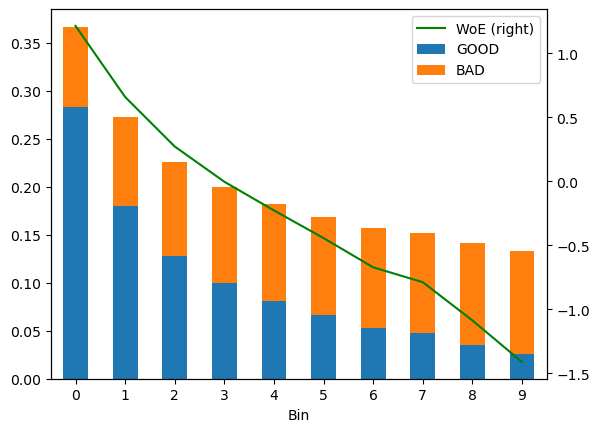

In [ ]:
temp = update_temp1
# temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
# NEW_EXTSOURCE_MEAN cang lon thi khach hang cang bad 

#### EXT_SOURCE_3

In [ ]:
# EXT_SOURCE_3

temp2 = df_included[df_included['Variable'] == 'EXT_SOURCE_3']
temp2['Bin']= [i for i in range(temp2.shape[0])] 
temp2.loc[10, 'Bin'] = -1
temp2 = temp2.sort_values(by = ['Bin'])
temp2 = temp2.reset_index().drop(columns = ['index'])
temp2['Bin'] = [i for i in range(temp2.shape[0])] 
temp2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV,Bin
0,EXT_SOURCE_3,Missing,41499,3842,0.228922,37657,0.195804,0.156268,5.175336e-03,0
1,EXT_SOURCE_3,"(-0.000473, 0.228]",16876,3355,0.199905,13521,0.070305,1.045002,1.354322e-01,1
2,EXT_SOURCE_3,"(0.228, 0.33]",16729,2090,0.124531,14639,0.076118,0.492269,2.383215e-02,2
3,EXT_SOURCE_3,"(0.33, 0.408]",17098,1653,0.098493,15445,0.080309,0.204101,3.711298e-03,3
4,EXT_SOURCE_3,"(0.408, 0.476]",16719,1342,0.079962,15377,0.079955,0.000082,5.420307e-10,4
5,EXT_SOURCE_3,"(0.476, 0.537]",16763,1023,0.060955,15740,0.081843,-0.294672,6.155166e-03,5
6,EXT_SOURCE_3,"(0.537, 0.592]",16684,873,0.052017,15811,0.082212,-0.457731,1.382121e-02,6
7,EXT_SOURCE_3,"(0.592, 0.643]",16892,797,0.047489,16095,0.083689,-0.566615,2.051153e-02,7
8,EXT_SOURCE_3,"(0.643, 0.694]",16981,733,0.043675,16248,0.084484,-0.659785,2.692521e-02,8
9,EXT_SOURCE_3,"(0.694, 0.749]",16147,537,0.031997,15610,0.081167,-0.930875,4.577124e-02,9


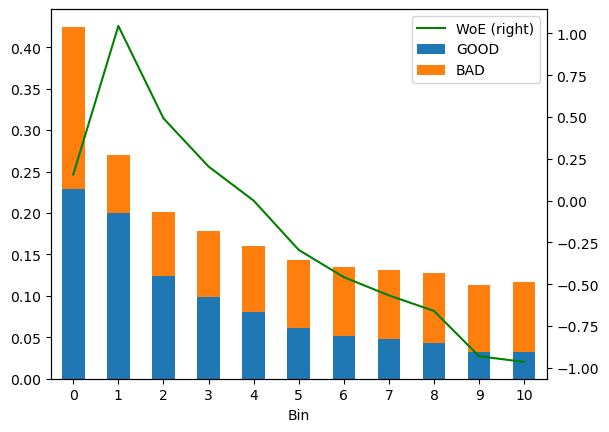

In [ ]:
temp = temp2
# temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

#### EXT_SOURCE_2

In [ ]:
temp3 = df_included[df_included['Variable'] == 'EXT_SOURCE_2']
temp3

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,EXT_SOURCE_2,"(-0.0009999183, 0.217]",20867,3790,0.225824,17077,0.088795,0.933428,0.127907
1,EXT_SOURCE_2,"(0.217, 0.341]",20868,2469,0.147113,18399,0.095669,0.430311,0.022137
2,EXT_SOURCE_2,"(0.341, 0.441]",20866,2025,0.120658,18841,0.097967,0.208329,0.004727
3,EXT_SOURCE_2,"(0.441, 0.512]",20866,1706,0.101650,19160,0.099626,0.020121,0.000041
4,EXT_SOURCE_2,"(0.512, 0.566]",20883,1585,0.094441,19298,0.100343,-0.060623,0.000358
5,EXT_SOURCE_2,"(0.566, 0.608]",20850,1434,0.085444,19416,0.100957,-0.166836,0.002588
6,EXT_SOURCE_2,"(0.608, 0.646]",20866,1250,0.074480,19616,0.101997,-0.314408,0.008651
7,EXT_SOURCE_2,"(0.646, 0.682]",20872,1021,0.060835,19851,0.103219,-0.528678,0.022407
8,EXT_SOURCE_2,"(0.682, 0.722]",20864,877,0.052255,19987,0.103926,-0.687536,0.035525
9,EXT_SOURCE_2,"(0.722, 0.855]",20864,601,0.035810,20263,0.105361,-1.079163,0.075057


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


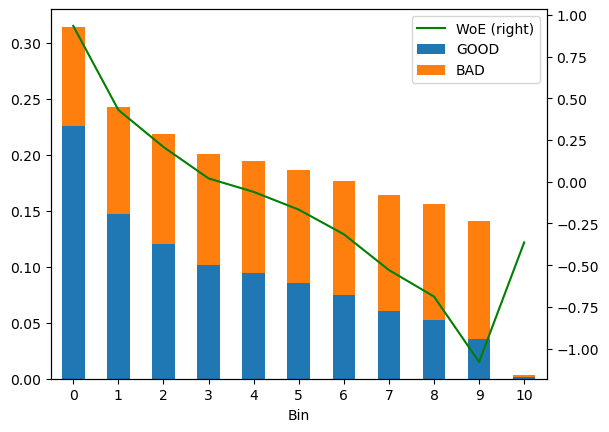

In [ ]:
temp = temp3
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

#### NEW_EXTSOURCES_WPOINT

In [ ]:
# agg_application_train
# df['NEW_EXTSOURCES_WPOINT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
temp4 = df_included[df_included['Variable'] == 'NEW_EXTSOURCES_WPOINT']
temp4

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,NEW_EXTSOURCES_WPOINT,"(-0.000999757, 0.0228]",7458,1697,0.101114,5761,0.029955,1.216545,0.086568
1,NEW_EXTSOURCES_WPOINT,"(0.0228, 0.0447]",7458,1015,0.060478,6443,0.033501,0.590689,0.015935
2,NEW_EXTSOURCES_WPOINT,"(0.0447, 0.0679]",7458,683,0.040696,6775,0.035228,0.144294,0.000789
3,NEW_EXTSOURCES_WPOINT,"(0.0679, 0.0925]",7457,533,0.031758,6924,0.036002,-0.125433,0.000532
4,NEW_EXTSOURCES_WPOINT,"(0.0925, 0.12]",7458,432,0.025740,7026,0.036533,-0.350153,0.003779
5,NEW_EXTSOURCES_WPOINT,"(0.12, 0.152]",7458,332,0.019782,7126,0.037053,-0.627576,0.010839
6,NEW_EXTSOURCES_WPOINT,"(0.152, 0.189]",7457,270,0.016088,7187,0.037370,-0.842813,0.017937
7,NEW_EXTSOURCES_WPOINT,"(0.189, 0.235]",7458,215,0.012811,7243,0.037661,-1.078359,0.026798
8,NEW_EXTSOURCES_WPOINT,"(0.235, 0.301]",7458,145,0.008640,7313,0.038025,-1.481881,0.043546
9,NEW_EXTSOURCES_WPOINT,"(0.301, 0.619]",7458,95,0.005660,7363,0.038285,-1.911552,0.062364


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


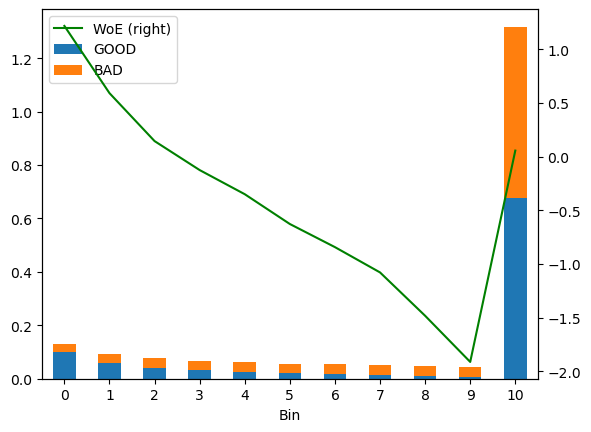

In [ ]:
temp = temp4
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

#### EXT_SOURCE_1

In [ ]:
temp5 = df_included[df_included['Variable'] == 'EXT_SOURCE_1']
temp5

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,EXT_SOURCE_1,"(0.013600000000000001, 0.213]",9135,1605,0.095632,7530,0.039153,0.893023,0.050437
1,EXT_SOURCE_1,"(0.213, 0.297]",9136,1060,0.063159,8076,0.041993,0.408166,0.008640
2,EXT_SOURCE_1,"(0.297, 0.369]",9134,831,0.049514,8303,0.043173,0.137052,0.000869
3,EXT_SOURCE_1,"(0.369, 0.437]",9135,752,0.044807,8383,0.043589,0.027569,0.000034
4,EXT_SOURCE_1,"(0.437, 0.506]",9135,627,0.037359,8508,0.044239,-0.169021,0.001163
5,EXT_SOURCE_1,"(0.506, 0.572]",9135,563,0.033546,8572,0.044572,-0.284183,0.003133
6,EXT_SOURCE_1,"(0.572, 0.64]",9135,454,0.027051,8681,0.045138,-0.512001,0.009261
7,EXT_SOURCE_1,"(0.64, 0.71]",9135,401,0.023893,8734,0.045414,-0.642223,0.013821
8,EXT_SOURCE_1,"(0.71, 0.787]",9135,312,0.018590,8823,0.045877,-0.903320,0.024648
9,EXT_SOURCE_1,"(0.787, 0.963]",9135,225,0.013406,8910,0.046329,-1.240035,0.040825


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


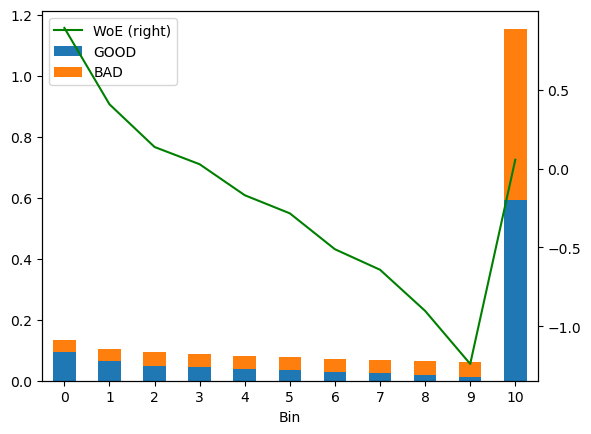

In [ ]:
temp = temp5
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

#### BURO_NEW_DEPT_RATIO_MAX

In [ ]:
# agg_pos_cash_time
# bureau_and_bb['NEW_DEPT_RATIO'] = bureau_and_bb['AMT_CREDIT_SUM_DEBT'] / (bureau_and_bb['AMT_CREDIT_SUM']+1)
#### +1 +> Mau so != 0
# 'NEW_DEPT_RATIO': ['min','max','mean'] : groupby level SK_ID_CURR
# BURO_NEW_DEPT_RATIO_MAX

temp6 = woeDF[woeDF['Variable'] == 'BURO_NEW_DEPT_RATIO_MEAN']
iv = np.sum(temp6['IV'])
print('IV ', iv)
temp6

IV  0.13674401297827882


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,BURO_NEW_DEPT_RATIO_MEAN,"(-1037487.0460000001, 0.0]",49624,2821,0.168087,46803,0.243360,-0.370062,0.027856
1,BURO_NEW_DEPT_RATIO_MEAN,"(0.0, 0.0247]",2612,109,0.006495,2503,0.013015,-0.695103,0.004532
2,BURO_NEW_DEPT_RATIO_MEAN,"(0.0247, 0.116]",17412,819,0.048799,16593,0.086278,-0.569858,0.021358
3,BURO_NEW_DEPT_RATIO_MEAN,"(0.116, 0.178]",17412,986,0.058750,16426,0.085410,-0.374170,0.009975
4,BURO_NEW_DEPT_RATIO_MEAN,"(0.178, 0.243]",17412,1136,0.067688,16276,0.084630,-0.223384,0.003785
5,BURO_NEW_DEPT_RATIO_MEAN,"(0.243, 0.318]",17412,1407,0.083835,16005,0.083221,0.007353,0.000005
6,BURO_NEW_DEPT_RATIO_MEAN,"(0.318, 0.425]",17412,1721,0.102544,15691,0.081588,0.228612,0.004791
7,BURO_NEW_DEPT_RATIO_MEAN,"(0.425, 0.608]",17412,2039,0.121492,15373,0.079934,0.418641,0.017398
8,BURO_NEW_DEPT_RATIO_MEAN,"(0.608, 2233309.746]",17412,2422,0.144313,14990,0.077943,0.616005,0.040884
9,BURO_NEW_DEPT_RATIO_MEAN,Missing,34983,3323,0.197998,31660,0.164621,0.184608,0.006162


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


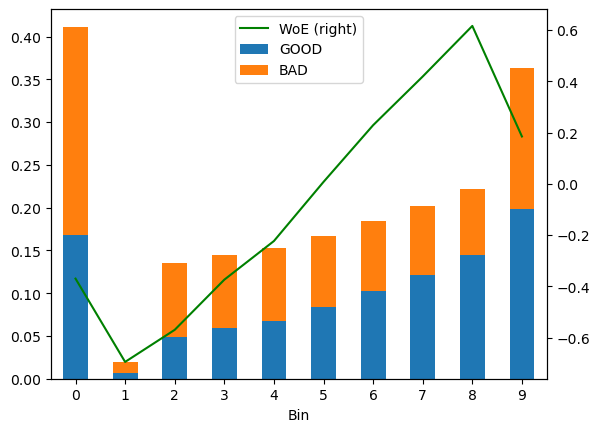

In [ ]:
temp = temp6
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

In [ ]:
temp6 = woeDF[woeDF['Variable'] == 'BURO_NEW_DEPT_RATIO_MEAN']
temp6['Bin']= [i for i in range(temp6.shape[0])] 
temp6.loc[9, 'Bin'] = -1
temp6 = temp6.sort_values(by = ['Bin'])
temp6 = temp6.reset_index().drop(columns = ['index'])
temp6['Bin'] = [i for i in range(temp6.shape[0])] 
temp6

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV,Bin
0,BURO_NEW_DEPT_RATIO_MEAN,Missing,34983,3323,0.197998,31660,0.164621,0.184608,0.006162,0
1,BURO_NEW_DEPT_RATIO_MEAN,"(-1037487.0460000001, 0.0]",49624,2821,0.168087,46803,0.243360,-0.370062,0.027856,1
2,BURO_NEW_DEPT_RATIO_MEAN,"(0.0, 0.0247]",2612,109,0.006495,2503,0.013015,-0.695103,0.004532,2
3,BURO_NEW_DEPT_RATIO_MEAN,"(0.0247, 0.116]",17412,819,0.048799,16593,0.086278,-0.569858,0.021358,3
4,BURO_NEW_DEPT_RATIO_MEAN,"(0.116, 0.178]",17412,986,0.058750,16426,0.085410,-0.374170,0.009975,4
5,BURO_NEW_DEPT_RATIO_MEAN,"(0.178, 0.243]",17412,1136,0.067688,16276,0.084630,-0.223384,0.003785,5
6,BURO_NEW_DEPT_RATIO_MEAN,"(0.243, 0.318]",17412,1407,0.083835,16005,0.083221,0.007353,0.000005,6
7,BURO_NEW_DEPT_RATIO_MEAN,"(0.318, 0.425]",17412,1721,0.102544,15691,0.081588,0.228612,0.004791,7
8,BURO_NEW_DEPT_RATIO_MEAN,"(0.425, 0.608]",17412,2039,0.121492,15373,0.079934,0.418641,0.017398,8
9,BURO_NEW_DEPT_RATIO_MEAN,"(0.608, 2233309.746]",17412,2422,0.144313,14990,0.077943,0.616005,0.040884,9


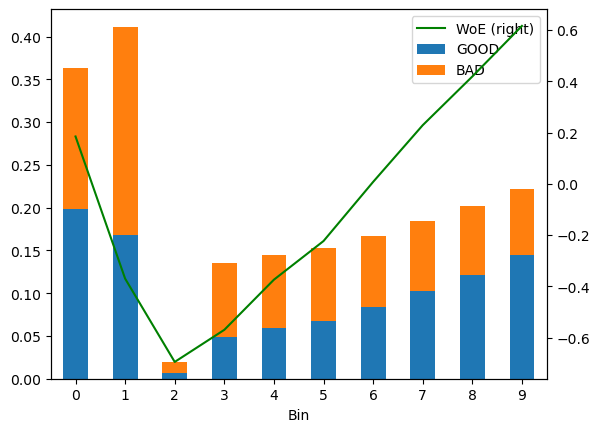

In [ ]:
temp = temp6
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
# cutoff vao diem 0 : Debt = 0 

#### ACTIVE_NEW_DEPT_RATIO_MAX

In [ ]:
# ACTIVE_NEW_DEPT_RATIO_MAX

temp7 = woeDF[woeDF['Variable'] == 'ACTIVE_NEW_DEPT_RATIO_MAX']
temp7['Bin']= [i for i in range(temp7.shape[0])] 
temp7.loc[10, 'Bin'] = -1
temp7 = temp7.sort_values(by = ['Bin'])
temp7 = temp7.reset_index().drop(columns = ['index'])
temp7['Bin'] = [i for i in range(temp7.shape[0])] 
temp7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV,Bin
0,ACTIVE_NEW_DEPT_RATIO_MAX,Missing,68423,5249,0.312757,63174,0.328484,-0.049061,0.000772,0
1,ACTIVE_NEW_DEPT_RATIO_MAX,"(-152983.036, 0.0]",15700,841,0.050110,14859,0.077262,-0.432975,0.011756,1
2,ACTIVE_NEW_DEPT_RATIO_MAX,"(0.0, 0.379]",12436,625,0.037240,11811,0.061413,-0.500241,0.012092,2
3,ACTIVE_NEW_DEPT_RATIO_MAX,"(0.379, 0.631]",14068,679,0.040458,13389,0.069618,-0.542773,0.015828,3
4,ACTIVE_NEW_DEPT_RATIO_MAX,"(0.631, 0.773]",14068,802,0.047786,13266,0.068979,-0.367057,0.007779,4
5,ACTIVE_NEW_DEPT_RATIO_MAX,"(0.773, 0.861]",14068,943,0.056188,13125,0.068246,-0.194414,0.002344,5
6,ACTIVE_NEW_DEPT_RATIO_MAX,"(0.861, 0.919]",14068,1041,0.062027,13027,0.067736,-0.088048,0.000503,6
7,ACTIVE_NEW_DEPT_RATIO_MAX,"(0.919, 0.954]",14068,1295,0.077161,12773,0.066415,0.149971,0.001612,7
8,ACTIVE_NEW_DEPT_RATIO_MAX,"(0.954, 0.987]",14068,1529,0.091104,12539,0.065199,0.334564,0.008667,8
9,ACTIVE_NEW_DEPT_RATIO_MAX,"(0.987, 1.002]",14068,1557,0.092772,12511,0.065053,0.354947,0.009839,9


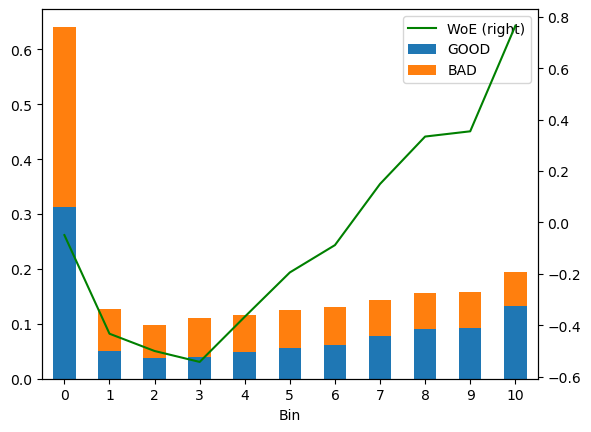

In [ ]:
temp = temp7
# temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
## cutoff bin 3 = 0 => debt = 0 

#### BURO_DAYS_CREDIT_MEAN

In [ ]:
# agg_bureau_and_balance ( bang bureau : How many days before current application did client apply for Credit Bureau credit)
# 'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
## Missing la client dang trong khoan vay 
# BURO_DAYS_CREDIT_MEAN
temp8 = woeDF[woeDF['Variable'] == 'BURO_DAYS_CREDIT_MEAN']
temp8

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,BURO_DAYS_CREDIT_MEAN,"(-2922.001, -1807.5]",17918,904,0.053864,17014,0.088467,-0.496168,0.017169
1,BURO_DAYS_CREDIT_MEAN,"(-1807.5, -1528.107]",17915,874,0.052077,17041,0.088608,-0.531503,0.019416
2,BURO_DAYS_CREDIT_MEAN,"(-1528.107, -1347.75]",17919,985,0.058690,16934,0.088051,-0.405643,0.011910
3,BURO_DAYS_CREDIT_MEAN,"(-1347.75, -1195.667]",17914,1076,0.064112,16838,0.087552,-0.311594,0.007304
4,BURO_DAYS_CREDIT_MEAN,"(-1195.667, -1052.0]",17942,1174,0.069952,16768,0.087188,-0.220261,0.003796
5,BURO_DAYS_CREDIT_MEAN,"(-1052.0, -904.729]",17889,1254,0.074718,16635,0.086496,-0.146376,0.001724
6,BURO_DAYS_CREDIT_MEAN,"(-904.729, -749.0]",17935,1466,0.087350,16469,0.085633,0.019852,0.000034
7,BURO_DAYS_CREDIT_MEAN,"(-749.0, -575.0]",17908,1665,0.099208,16243,0.084458,0.160957,0.002374
8,BURO_DAYS_CREDIT_MEAN,"(-575.0, -370.25]",17906,1926,0.114759,15980,0.083091,0.322902,0.010226
9,BURO_DAYS_CREDIT_MEAN,"(-370.25, -2.0]",17916,2457,0.146398,15459,0.080382,0.599544,0.039580


In [ ]:
1807/365

4.950684931506849

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


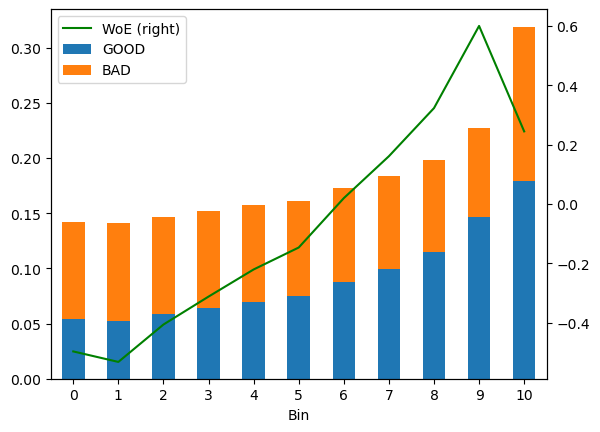

In [ ]:
temp = temp8
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
# cutoff nhe o diem 5 nam


#### DAYS_EMPLOYED

In [ ]:
# application_{train|test}.csv
# DAYS_EMPLOYED : How many days before the application the person started current employment
temp9 = woeDF[woeDF['Variable'] == 'DAYS_EMPLOYED']
temp9['Bin']= [i for i in range(temp9.shape[0])] 
temp9.loc[10, 'Bin'] = -1
temp9 = temp9.sort_values(by = ['Bin'])
temp9 = temp9.reset_index().drop(columns = ['index'])
temp9['Bin'] = [i for i in range(temp9.shape[0])] 
temp9

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV,Bin
0,DAYS_EMPLOYED,Missing,37557,2008,0.119645,35549,0.184843,-0.434979,0.028360,0
1,DAYS_EMPLOYED,"(-17912.001, -5332.0]",17162,766,0.045641,16396,0.085254,-0.624816,0.024750,1
2,DAYS_EMPLOYED,"(-5332.0, -3682.0]",17149,985,0.058690,16164,0.084047,-0.359106,0.009106,2
3,DAYS_EMPLOYED,"(-3682.0, -2796.0]",17159,1142,0.068045,16017,0.083283,-0.202075,0.003079,3
4,DAYS_EMPLOYED,"(-2796.0, -2160.0]",17176,1302,0.077579,15874,0.082540,-0.061987,0.000308,4
5,DAYS_EMPLOYED,"(-2160.0, -1649.0]",17136,1464,0.087231,15672,0.081489,0.068091,0.000391,5
6,DAYS_EMPLOYED,"(-1649.0, -1249.0]",17162,1639,0.097658,15523,0.080714,0.190558,0.003229,6
7,DAYS_EMPLOYED,"(-1249.0, -918.0]",17188,1752,0.104391,15436,0.080262,0.262850,0.006342,7
8,DAYS_EMPLOYED,"(-918.0, -616.0]",17127,1899,0.113150,15228,0.079181,0.356986,0.012127,8
9,DAYS_EMPLOYED,"(-616.0, -331.0]",17169,1944,0.115831,15225,0.079165,0.380603,0.013955,9


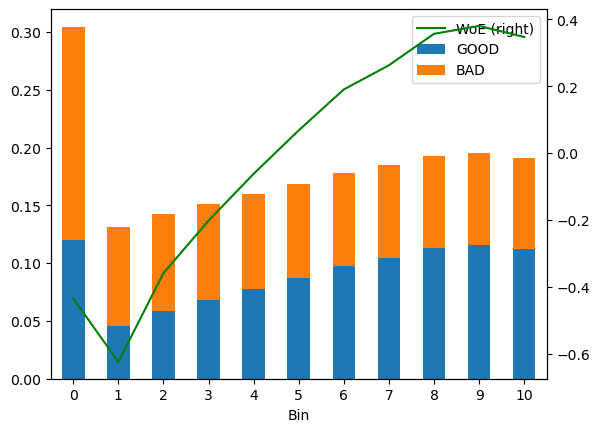

In [ ]:
temp = temp9
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
## Missing la dang co viec lam

	Logit				LGBM	
	Variable	IV			Variable	
0	NEW_EXTSOURCE_MEAN	0.597736	1		NEW_EXTSOURCE_MEAN	1
1	EXT_SOURCE_3	0.331556	1		EXT_SOURCE_3	1
2	EXT_SOURCE_2	0.299635	1		ACTIVE_NEW_DEBT_RATIO_MAX	1
3	NEW_EXTSOURCES_WPOINT	0.271148	1		EXT_SOURCE_2	1
4	EXT_SOURCE_1	0.154664			NEW_PAYMENT_RATIO	1
5	BURO_NEW_DEPT_RATIO_MAX	0.14524			INSTAL_DPD_MEAN	
6	BURO_NEW_DEPT_RATIO_MEAN	0.136744			NEW_DAYS_EMPLOYED_RATIO	1
7	ACTIVE_NEW_DEPT_RATIO_MAX	0.125368	1		NEW_GOODS_CREDIT_DIFF_RATIO	
8	BURO_DAYS_CREDIT_MEAN	0.123019			CC_CNT_DRAWINGS_ATM_CURRENT_MEAN	
9	DAYS_EMPLOYED	0.113084			PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN	
10	BURO_NEWS_DAYS_CREDIT_UPDATE_new_MEAN	0.098125			AMT_ANNUITY	
11	BURO_DAYS_CREDIT_UPDATE_MEAN	0.094691			INSTALL_AMT_PAYMENT_SUM	
12	BURO_CREDIT_ACTIVE_Active_MEAN	0.093944			NEW_EXTSOURCE_WPOINT	1
13	BURO_NEWS_DAYS_CREDIT_UPDATE_old_MEAN	0.093706			CODE_GENDER	
14	NEW_DAYS_EMPLOYED_RATIO	0.092489	1		OWN_CAR_AGE	
15	NEW_PAYMENT_RATIO	0.091283	1		NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL	
16	AMT_GOODS_PRICE	0.089721	1		PREV_CNT_PAYEMENT_MAX	
17	BURO_CREDIT_ACTIVE_Closed_MEAN	0.0883			PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN	
18	ACTIVE_NEW_DEPT_RATIO_MEAN	0.086021			AMT_GOODS_PRICE	1
19	NEW_DAYS_BIRTH	0.085637			INSTALL_PAYMENT_DIFF_MEAN	
			8			8
